<a href="https://colab.research.google.com/github/aregeezra/ChurnDetection/blob/main/ChurnDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy, math

from IPython.core.display  import HTML
from IPython.display       import Image
from datetime              import date
from scipy.stats           import chi2_contingency

from sklearn.ensemble      import RandomForestRegressor

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
import xgboost as           xgb

import random
import warnings
warnings.filterwarnings( 'ignore' )
np.set_printoptions(precision=2) 

#0.1 Helper Function

In [ ]:
def settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):

  """
  Plot stacked bars with annotations
  """
  ax = dataframe.plot(kind="bar",
                    stacked=True,
                    figsize=size_,
                    rot=rot_,
                    title=title_)
  # Annotate bars
  annotate_stacked_bars(ax, textsize=14)
  # Rename legend
  plt.legend(["Retained", "Churned"], loc=legend_)
  # Labels
  plt.ylabel("Customer base (%)")
  plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
  """
  Add value annotations to the bars
  """
  # Iterate over the plotted rectanges/bars
  for p in ax.patches:
    # Calculate annotation
    value = str(round(p.get_height(),1))
    # If value is 0 do not annotate
    if value == '0.0':
     continue
    ax.annotate(value,
                ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
                color=colour,
                size=textsize,)

In [ ]:
settings()

Populating the interactive namespace from numpy and matplotlib


#0.2 Loading Data

In [ ]:
client = pd.read_csv("client_data.csv")
price = pd.read_csv("price_data.csv")

In [ ]:
client.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [ ]:
price.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


#1.0 Data Description

##1.1 Data Dimensions

In [ ]:
print( 'Number of Rows: {}'.format( client.shape[0] ) )
print( 'Number of Cols: {}'.format( client.shape[1] ) )

Number of Rows: 14606
Number of Cols: 26


In [ ]:
print( 'Number of Rows: {}'.format( price.shape[0] ) )
print( 'Number of Cols: {}'.format( price.shape[1] ) )

Number of Rows: 88413
Number of Cols: 8


## 1.2 Data Types

In [ ]:
client.dtypes

id                                 object
channel_sales                      object
cons_12m                            int64
cons_gas_12m                        int64
cons_last_month                     int64
date_activ                         object
date_end                           object
date_modif_prod                    object
date_renewal                       object
forecast_cons_12m                 float64
forecast_cons_year                  int64
forecast_discount_energy          float64
forecast_meter_rent_12m           float64
forecast_price_energy_off_peak    float64
forecast_price_energy_peak        float64
forecast_price_pow_off_peak       float64
has_gas                            object
imp_cons                          float64
margin_gross_pow_ele              float64
margin_net_pow_ele                float64
nb_prod_act                         int64
net_margin                        float64
num_years_antig                     int64
origin_up                         

In [ ]:
price.dtypes

id                     object
price_date             object
price_off_peak_var    float64
price_peak_var        float64
price_mid_peak_var    float64
price_off_peak_fix    float64
price_peak_fix        float64
price_mid_peak_fix    float64
dtype: object

### 1.2.2 Change Data Types

In [ ]:
client["date_activ"] = pd.to_datetime(client["date_activ"],format='%Y-%m-%d')
client["date_end"] = pd.to_datetime(client["date_end"], format='%Y-%m-%d')
client["date_modif_prod"] = pd.to_datetime(client["date_modif_prod"],format='%Y-%m-%d')
client["date_renewal"] = pd.to_datetime(client["date_renewal"],format='%Y-%m-%d')
price['price_date'] = pd.to_datetime(price['price_date'],format='%Y-%m-%d')


##1.3 Check NA

In [ ]:
client.isna().sum()

id                                0
channel_sales                     0
cons_12m                          0
cons_gas_12m                      0
cons_last_month                   0
date_activ                        0
date_end                          0
date_modif_prod                   0
date_renewal                      0
forecast_cons_12m                 0
forecast_cons_year                0
forecast_discount_energy          0
forecast_meter_rent_12m           0
forecast_price_energy_off_peak    0
forecast_price_energy_peak        0
forecast_price_pow_off_peak       0
has_gas                           0
imp_cons                          0
margin_gross_pow_ele              0
margin_net_pow_ele                0
nb_prod_act                       0
net_margin                        0
num_years_antig                   0
origin_up                         0
pow_max                           0
churn                             0
dtype: int64

In [ ]:
pd.DataFrame({"Missing Values(%)":
              price.isna().sum()/len(price.index)*100})

,Missing Values(%)
id,0.000000
price_date,0.000000
price_off_peak_var,0.000000
price_peak_var,0.000000
price_mid_peak_var,0.000000
price_off_peak_fix,0.001131
price_peak_fix,0.001131
price_mid_peak_fix,0.001131


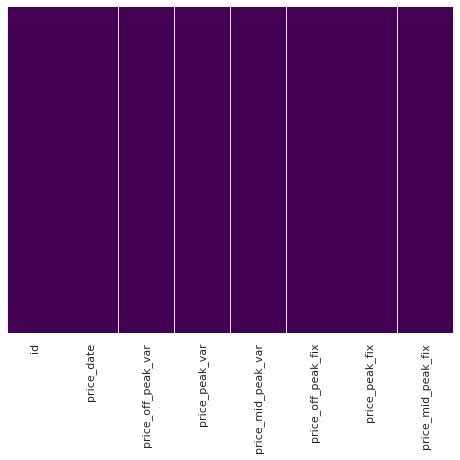

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(price.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
price.columns

Index(['id', 'price_date', 'price_off_peak_var', 'price_peak_var',
       'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix',
       'price_mid_peak_fix'],
      dtype='object')

##1.5 Descriptive Statistical

In [ ]:
# divide into numerical and categorical columns, as they will be treated with different techniques.
num_attributes = client.select_dtypes( include=['float64', 'int64'] )
cat_attributes = client.select_dtypes( exclude=['float64', 'datetime64[ns]', 'int64'] )

In [ ]:
# divide into numerical and categorical columns, as they will be treated with different techniques.
num_attributes2 = price.select_dtypes( include=['float64'] )
cat_attributes2 = price.select_dtypes( exclude=['float64', 'datetime64[ns]'] )

In [ ]:
num_attributes.sample()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
10693,2975,0,435,442.09,435,0.0,19.57,0.144902,0.0,44.311378,63.55,24.24,24.24,1,43.54,6,13.15,0


In [ ]:
cat_attributes.sample()

,id,channel_sales,has_gas,origin_up
5284,04da87035b8630fd9187afda5b23d0ad,lmkebamcaaclubfxadlmueccxoimlema,f,ldkssxwpmemidmecebumciepifcamkci


In [ ]:
num_attributes2.sample()


,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
69742,0.125254,0.103116,0.071174,40.565973,24.339578,16.226383


In [ ]:
cat_attributes2.sample()

,id
45854,e730f1614f4d978d48a2b6ed70d4eb52


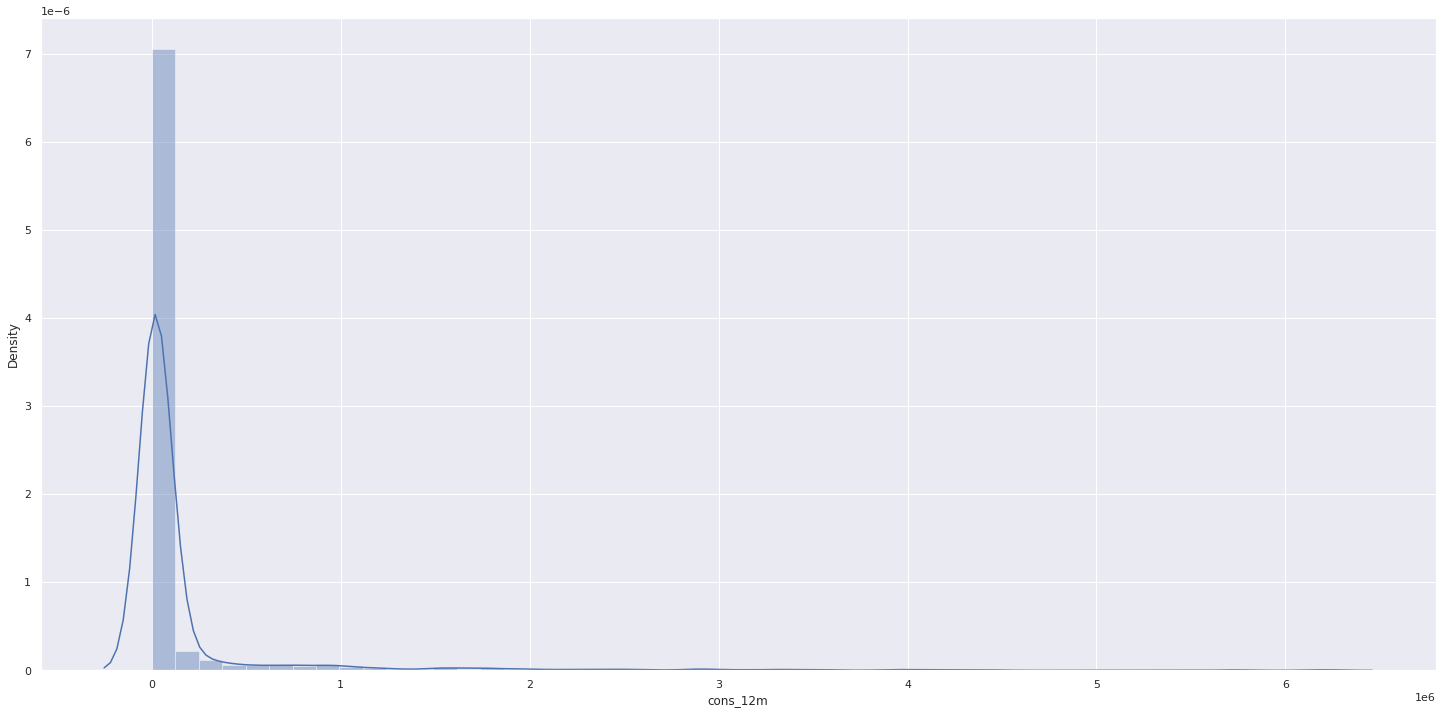

In [ ]:
sns.distplot( client['cons_12m'])

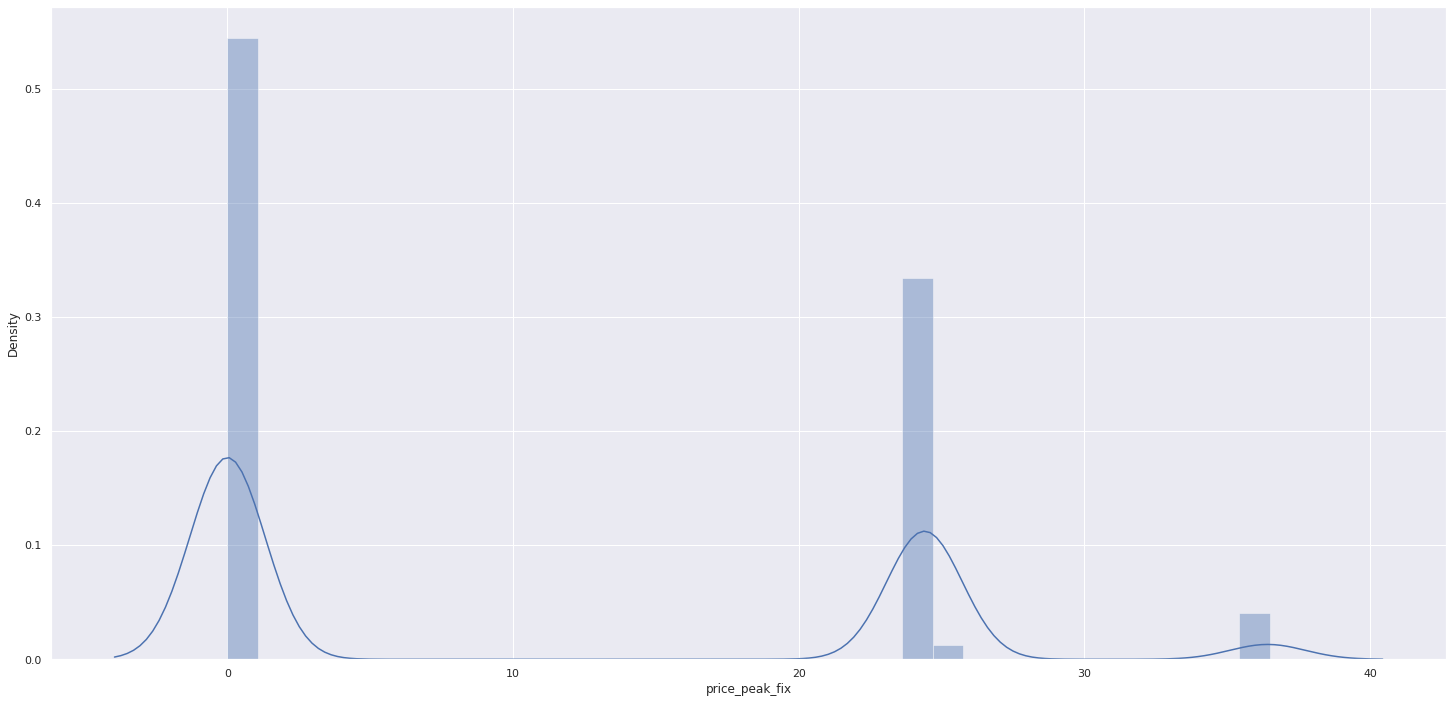

In [ ]:
sns.distplot( price['price_peak_fix'])

# 1.5.1  Numerical Attributes (Client)

In [ ]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
d7 = pd.DataFrame( num_attributes.apply (lambda x: x.var())).T
# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6, d7] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', "Variance"])

In [ ]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis,Variance
0,cons_12m,0.0,6.207104e+06,6.207104e+06,159220.286252,14115.500000,573445.632708,5.997308,42.689777,3.288624e+11
1,cons_gas_12m,0.0,4.154590e+06,4.154590e+06,28092.375325,0.000000,162967.479985,9.597530,126.333634,2.656022e+10
2,cons_last_month,0.0,7.712030e+05,7.712030e+05,16090.269752,792.500000,64361.993036,6.391407,47.762991,4.142750e+09
3,forecast_cons_12m,0.0,8.290283e+04,8.290283e+04,1868.614880,1112.875000,2387.489797,7.155853,147.426681,5.700498e+06
4,forecast_cons_year,0.0,1.753750e+05,1.753750e+05,1399.762906,314.000000,3247.675073,16.587990,653.734407,1.054812e+07
5,forecast_discount_energy,0.0,3.000000e+01,3.000000e+01,0.966726,0.000000,5.108114,5.155098,24.854712,2.609461e+01
6,forecast_meter_rent_12m,0.0,5.993100e+02,5.993100e+02,63.086871,18.795000,66.163518,1.505148,4.491521,4.377911e+03
7,forecast_price_energy_off_peak,0.0,2.739630e-01,2.739630e-01,0.137283,0.143166,0.024622,-0.119586,8.364539,6.062854e-04
8,forecast_price_energy_peak,0.0,1.959750e-01,1.959750e-01,0.050491,0.084138,0.049035,-0.014331,-1.890755,2.404579e-03
9,forecast_price_pow_off_peak,0.0,5.926638e+01,5.926638e+01,43.130056,44.311378,4.485835,-4.998772,54.708041,2.012409e+01


#1.5.2 Numerical Attributes (Price)

In [ ]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes2.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes2.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes2.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes2.apply( min ) ).T
d3 = pd.DataFrame( num_attributes2.apply( max ) ).T
d4 = pd.DataFrame( num_attributes2.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes2.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes2.apply( lambda x: x.kurtosis() ) ).T
d7 = pd.DataFrame( num_attributes2.apply (lambda x: x.var())).T
# concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6, d7] ).T.reset_index()
m1.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', "Variance"])

In [ ]:
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis,Variance
0,price_off_peak_var,0.0,0.280700,0.280700,0.140955,0.146033,0.024635,-0.195178,10.335579,0.000607
1,price_peak_var,0.0,0.181480,0.181480,0.053942,0.085390,0.050033,-0.107877,-1.892815,0.002503
2,price_mid_peak_var,0.0,0.114102,0.114102,0.030592,0.000000,0.036332,0.360680,-1.833425,0.001320
3,price_off_peak_fix,0.0,59.444710,59.444710,43.372143,NaN,5.324498,-2.693343,31.800482,28.350599
4,price_peak_fix,0.0,36.490692,36.490692,10.657628,NaN,12.858030,0.468698,-1.543577,165.330810
5,price_mid_peak_fix,0.0,17.458221,17.458221,6.421242,NaN,7.772521,0.430064,-1.765253,60.412760


## 1.5.3 Categorical Attributes

In [ ]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

id               14606
channel_sales        8
has_gas              2
origin_up            6
dtype: int64

In [ ]:
cat_attributes2.apply( lambda x: x.unique().shape[0] )

id    7374
dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

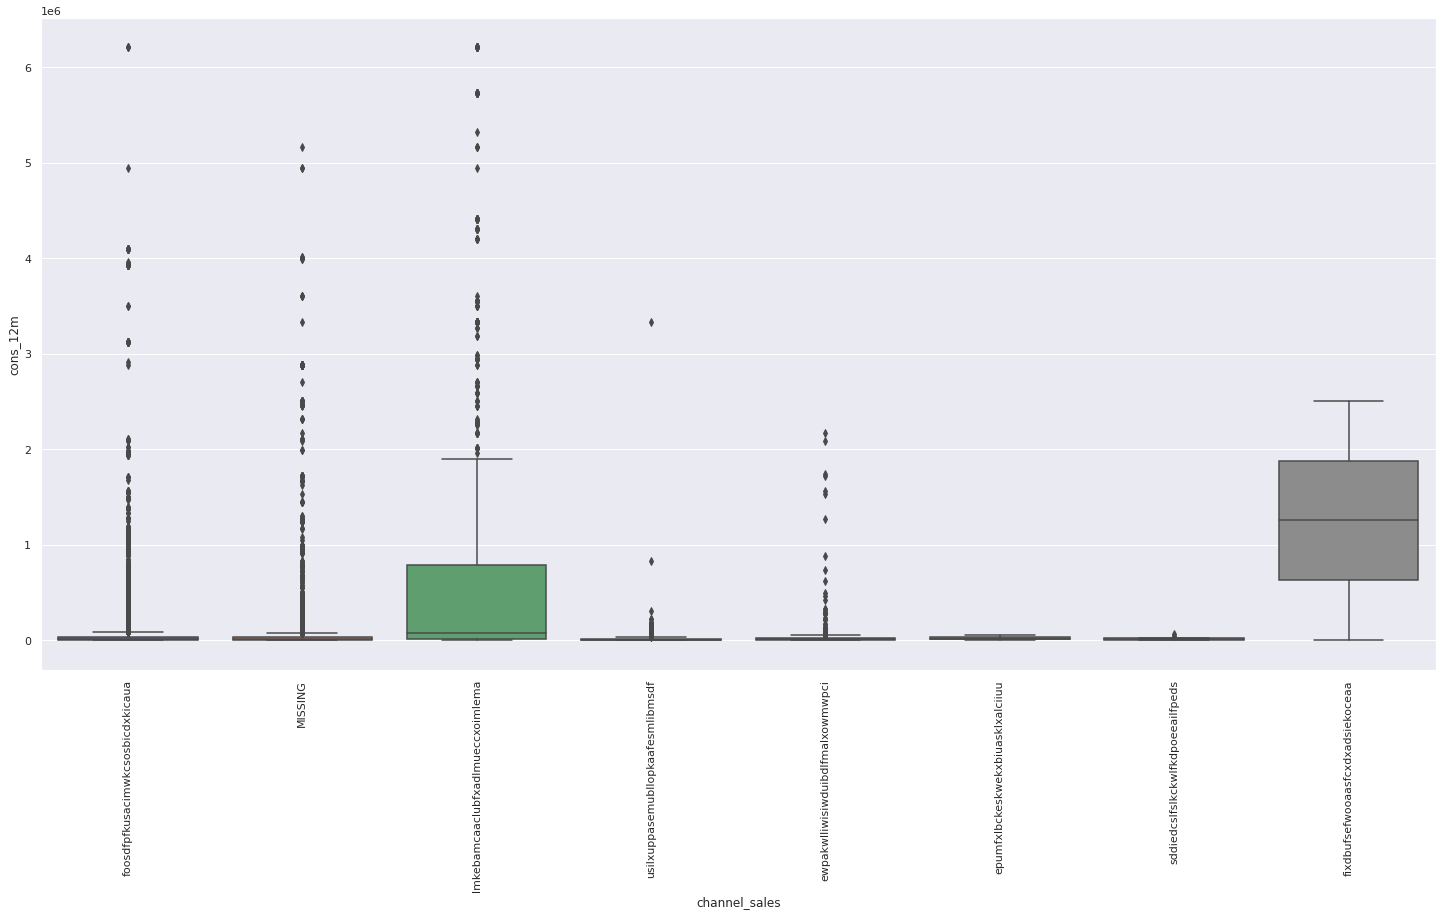

In [ ]:
sns.boxplot( x= 'channel_sales', y='cons_12m' , data=client )
plt.xticks(rotation=90)

#2.0 EXPLORATORY DATA ANALYSIS

##2.1 Univariate Analysis


### 2.1.1 Response Variable

In [ ]:
churn = client[['id', 'churn']]
churn.columns = ['Companies', 'churn']
churn_total = churn.groupby(churn['churn']).count()
churn_percentage = churn_total / churn_total.sum() * 100


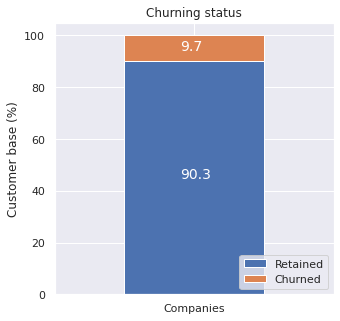

In [ ]:
plot_stacked_bars(churn_percentage.transpose(), "Churning status", (5, 5),legend_="lower right")

About 10% of Customers have churned

### 2.1.2 Numerical Variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47933c9d50>,
      dtype=object)

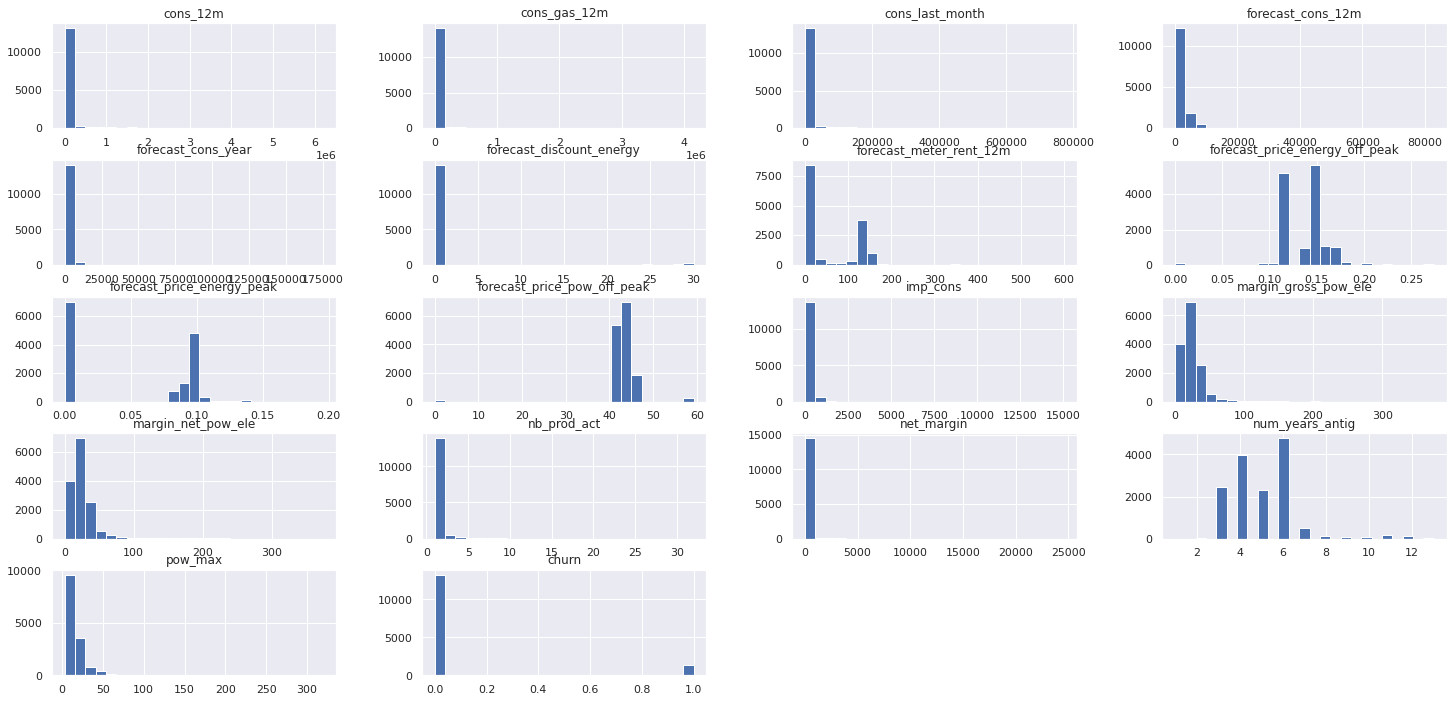

In [ ]:
num_attributes.hist( bins=25 )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f479349c390>,
      dtype=object)

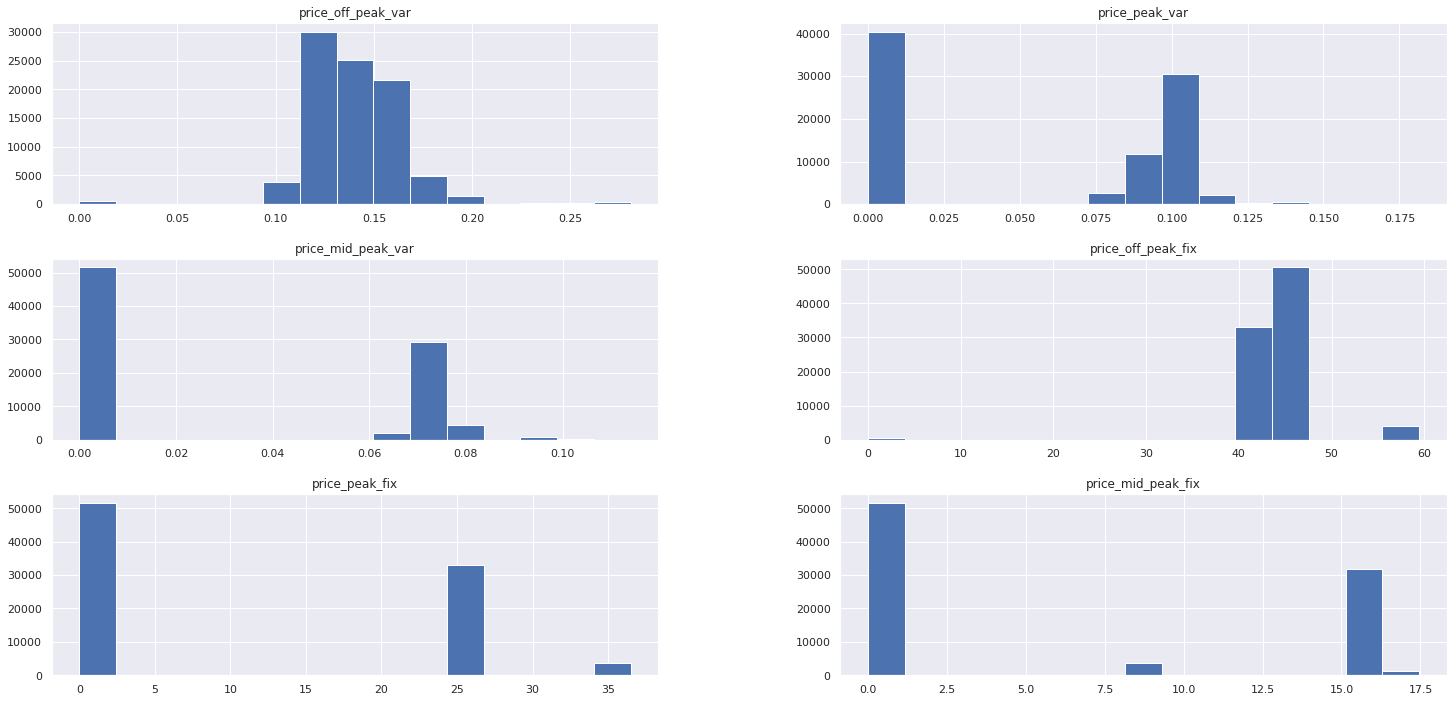

In [ ]:
num_attributes2.hist( bins=15 )

### 2.1.3 Categorical Variable

In [ ]:
client['channel_sales'].unique(
    
)

array(['foosdfpfkusacimwkcsosbicdxkicaua', 'MISSING',
       'lmkebamcaaclubfxadlmueccxoimlema',
       'usilxuppasemubllopkaafesmlibmsdf',
       'ewpakwlliwisiwduibdlfmalxowmwpci',
       'epumfxlbckeskwekxbiuasklxalciiuu',
       'sddiedcslfslkckwlfkdpoeeailfpeds',
       'fixdbufsefwooaasfcxdxadsiekoceaa'], dtype=object)

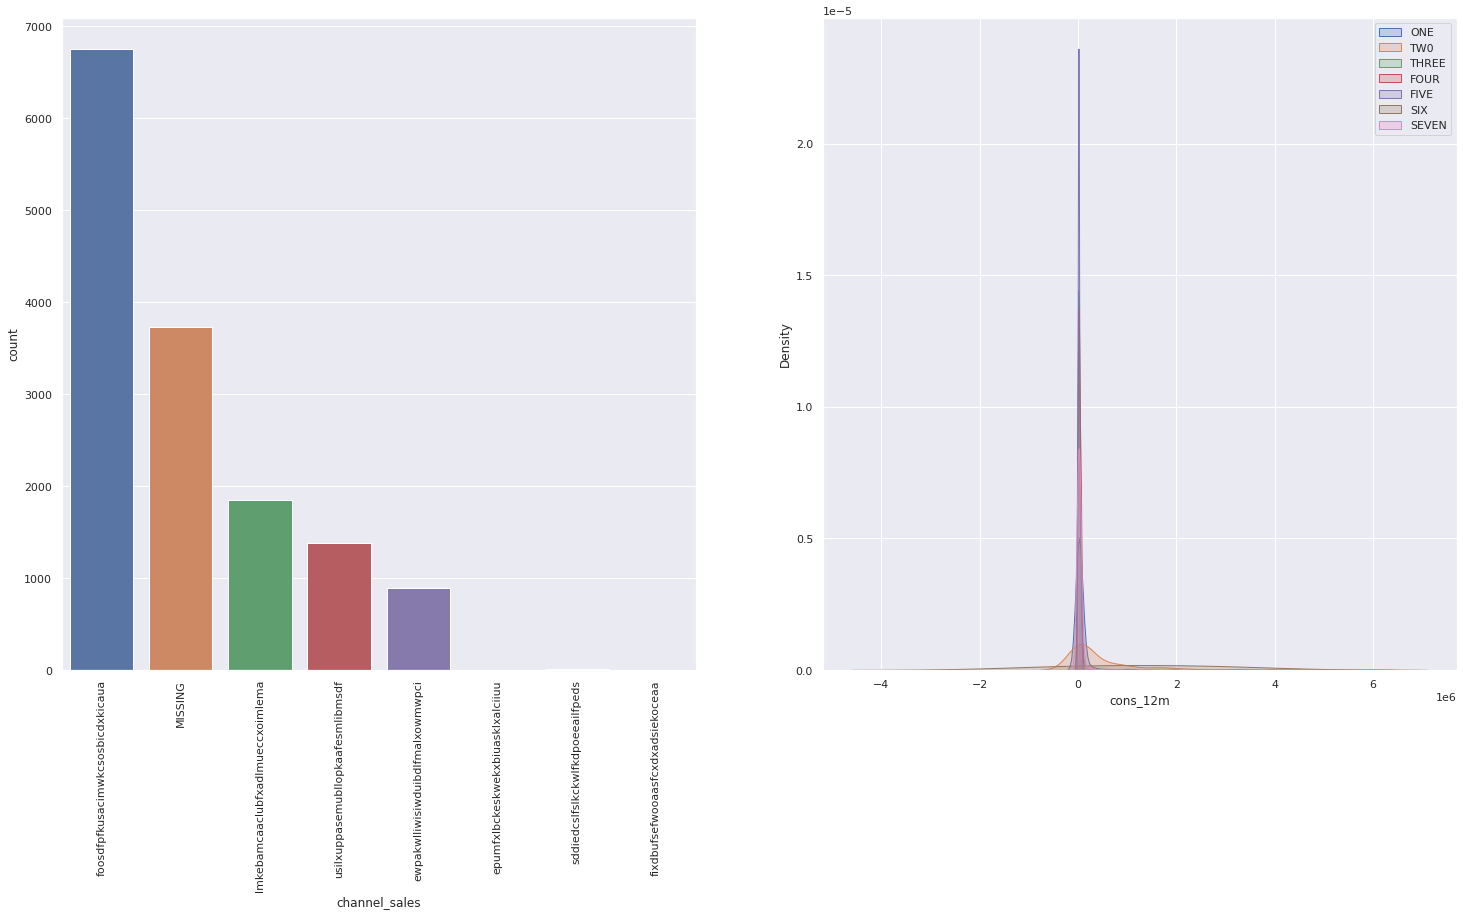

In [ ]:
# channell

plt.subplot( 1, 2, 1)
sns.countplot( client['channel_sales'] )
plt.xticks(rotation=90)

plt.subplot( 1, 2, 2)
sns.kdeplot( client[client['channel_sales'] == 'foosdfpfkusacimwkcsosbicdxkicaua']['cons_12m'],
            label='ONE', shade=True )

sns.kdeplot( client[client['channel_sales'] == 'lmkebamcaaclubfxadlmueccxoimlema']['cons_12m'],
            label='TW0', shade=True )

sns.kdeplot( client[client['channel_sales'] == 'usilxuppasemubllopkaafesmlibmsdf']['cons_12m'],
            label='THREE', shade=True )

sns.kdeplot( client[client['channel_sales'] == 'epumfxlbckeskwekxbiuasklxalciiuu']['cons_12m'],
            label='FOUR', shade=True )

sns.kdeplot( client[client['channel_sales'] == 'sddiedcslfslkckwlfkdpoeeailfpeds']['cons_12m'],
            label='FIVE', shade=True ) 

sns.kdeplot( client[client['channel_sales'] == 'fixdbufsefwooaasfcxdxadsiekoceaa']['cons_12m'],
            label='SIX', shade=True )  

sns.kdeplot( client[client['channel_sales'] == 'ewpakwlliwisiwduibdlfmalxowmwpci']['cons_12m'],
            label='SEVEN', shade=True )

plt.legend()

## 2.2 Bivariate Analysis

###  2.2.1 Sales Channel

In [ ]:
channel = client[['id', 'channel_sales', 'churn']]
channel = channel.groupby([channel['channel_sales'], channel['churn']])['id'].count().unstack(level=1).fillna(0)
channel_churn = (channel.div(channel.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)


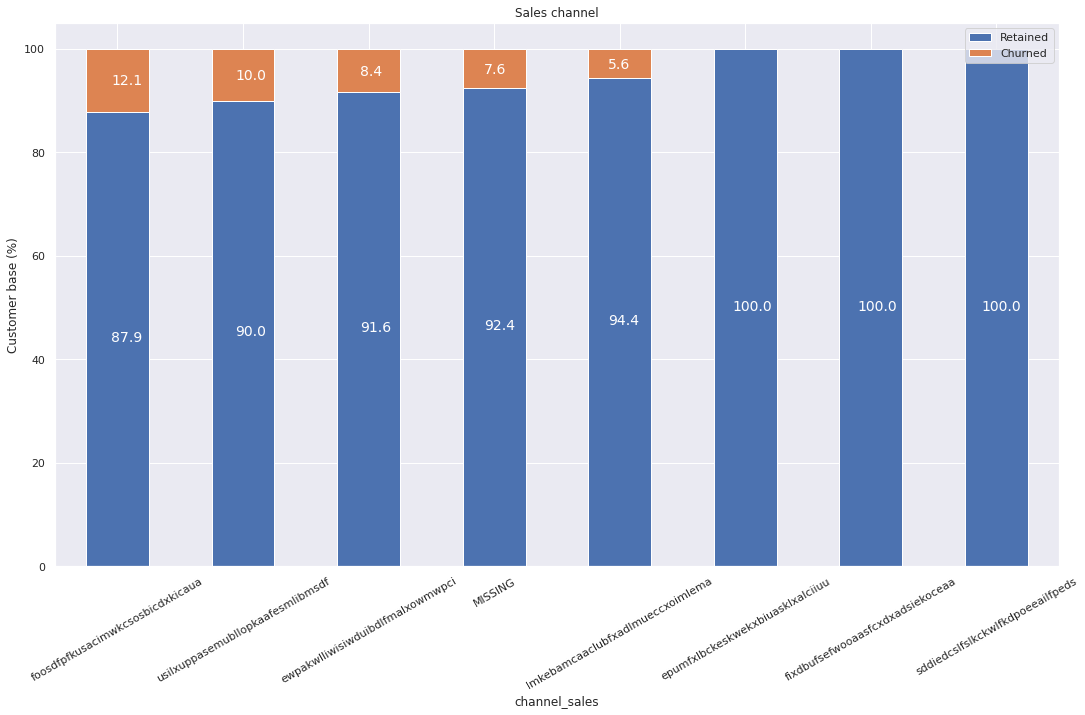

In [ ]:
plot_stacked_bars(channel_churn, 'Sales channel', rot_=30)

Interestingly, the churning customers are distributed over 5 different values for channel_sales. As
well as this, the value of MISSING has a churn rate of 7.6%. MISSING indicates a missing value and
was added by the team when they were cleaning the dataset. This feature could be an important
feature when it comes to building our model.


### 2.2.2 Consumption 

Let’s see the distribution of the consumption in the last year and month. Since the consumption
data is univariate, let’s use histograms to visualize their distribution.


In [ ]:
consumption = client[['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'imp_cons', 'has_gas', 'churn']]


In [ ]:
def plot_distribution(dataframe, column, ax, bins_=50):
  # "Plot variable distirbution in a stacked histogram of churned or retained company"

  # Create a temporal dataframe with the data to be plot
  temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
  "Churn":dataframe[dataframe["churn"]==1][column]})

  # Plot the histogram
  temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax,stacked=True)

  # X-axis label
  ax.set_xlabel(column)
  
  # Change the x-axis to plain style
  ax.ticklabel_format(style='plain', axis='x')

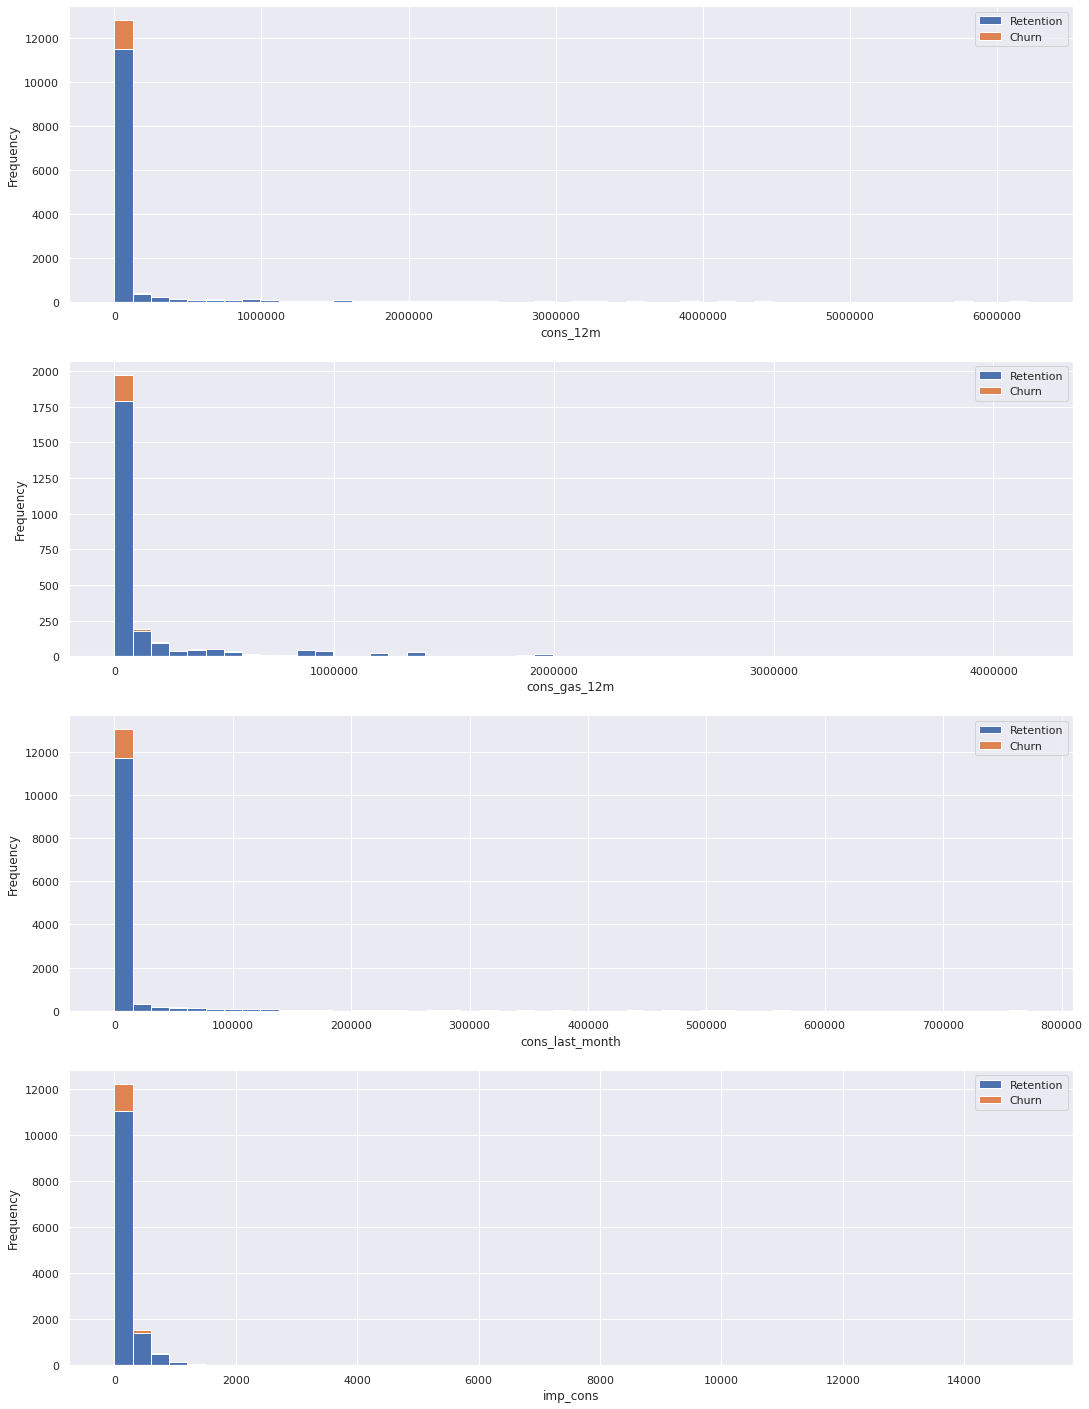

In [ ]:
fig, axs = plt.subplots(nrows=4, figsize=(18, 25))
plot_distribution(consumption, 'cons_12m', axs[0])
plot_distribution(consumption[consumption['has_gas'] == 't'], 'cons_gas_12m',axs[1])
plot_distribution(consumption, 'cons_last_month', axs[2])
plot_distribution(consumption, 'imp_cons', axs[3])

Clearly, the consumption data is highly positively skewed, presenting a very long right-tail towards
the higher values of the distribution. The values on the higher and lower end of the distribution are
likely to be outliers. We can use a standard plot to visualise the outliers in more detail. A boxplot
is a standardized way of displaying the distribution based on a five number summary:
 - Minimum
 - First quartile (Q1) - Median - Third quartile (Q3) - Maximum

It can reveal outliers and what their values are. It can also tell us if our data is symmetrical, how
tightly our data is grouped and if/how our data is skewed.

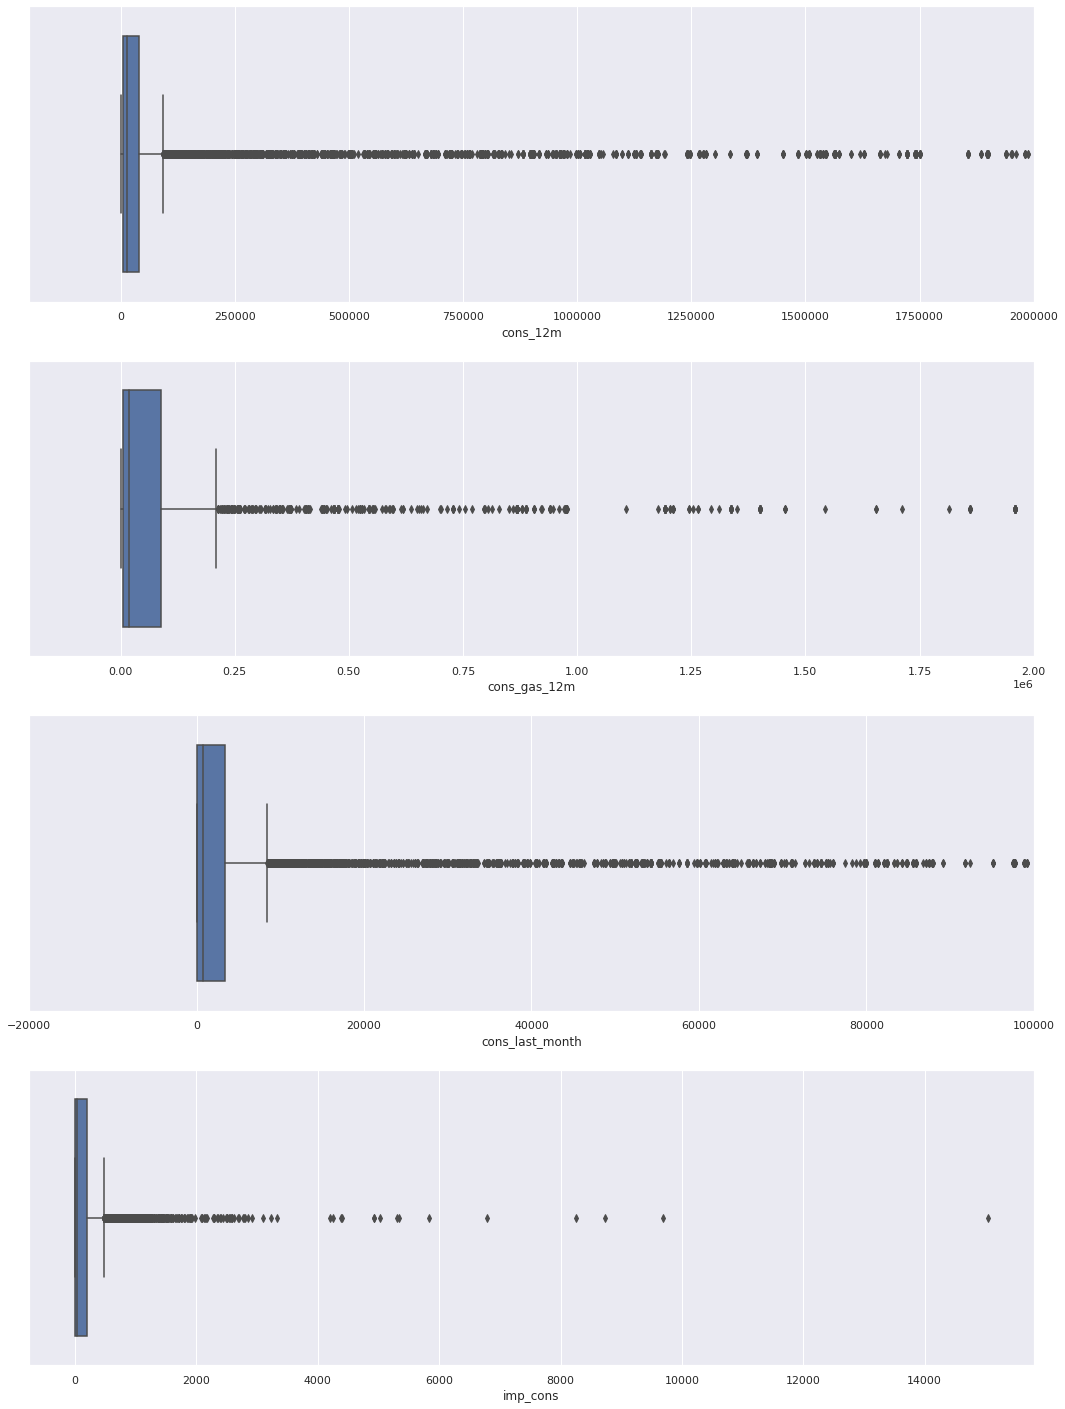

In [ ]:
fig, axs = plt.subplots(nrows=4, figsize=(18,25))
# Plot histogram
sns.boxplot(consumption["cons_12m"], ax=axs[0])
sns.boxplot(consumption[consumption["has_gas"] == "t"]["cons_gas_12m"],ax=axs[1])
sns.boxplot(consumption["cons_last_month"], ax=axs[2])
sns.boxplot(consumption["imp_cons"], ax=axs[3])
# Remove scientific notation
for ax in axs:
  ax.ticklabel_format(style='plain', axis='x')
  # Set x-axis limit
  axs[0].set_xlim(-200000, 2000000)
  axs[1].set_xlim(-200000, 2000000)
  axs[2].set_xlim(-20000, 100000)
  plt.show()


We will deal with skewness and outliers during feature engineering in the next court.

### 2.2.3 Forecast

In [ ]:
client.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn'],
      dtype='object')

In [ ]:
forecast = client[
["id", "forecast_cons_12m",
"forecast_cons_year","forecast_discount_energy","forecast_meter_rent_12m",
"forecast_price_energy_off_peak","forecast_price_energy_peak",
"forecast_price_pow_off_peak","churn"
]
]


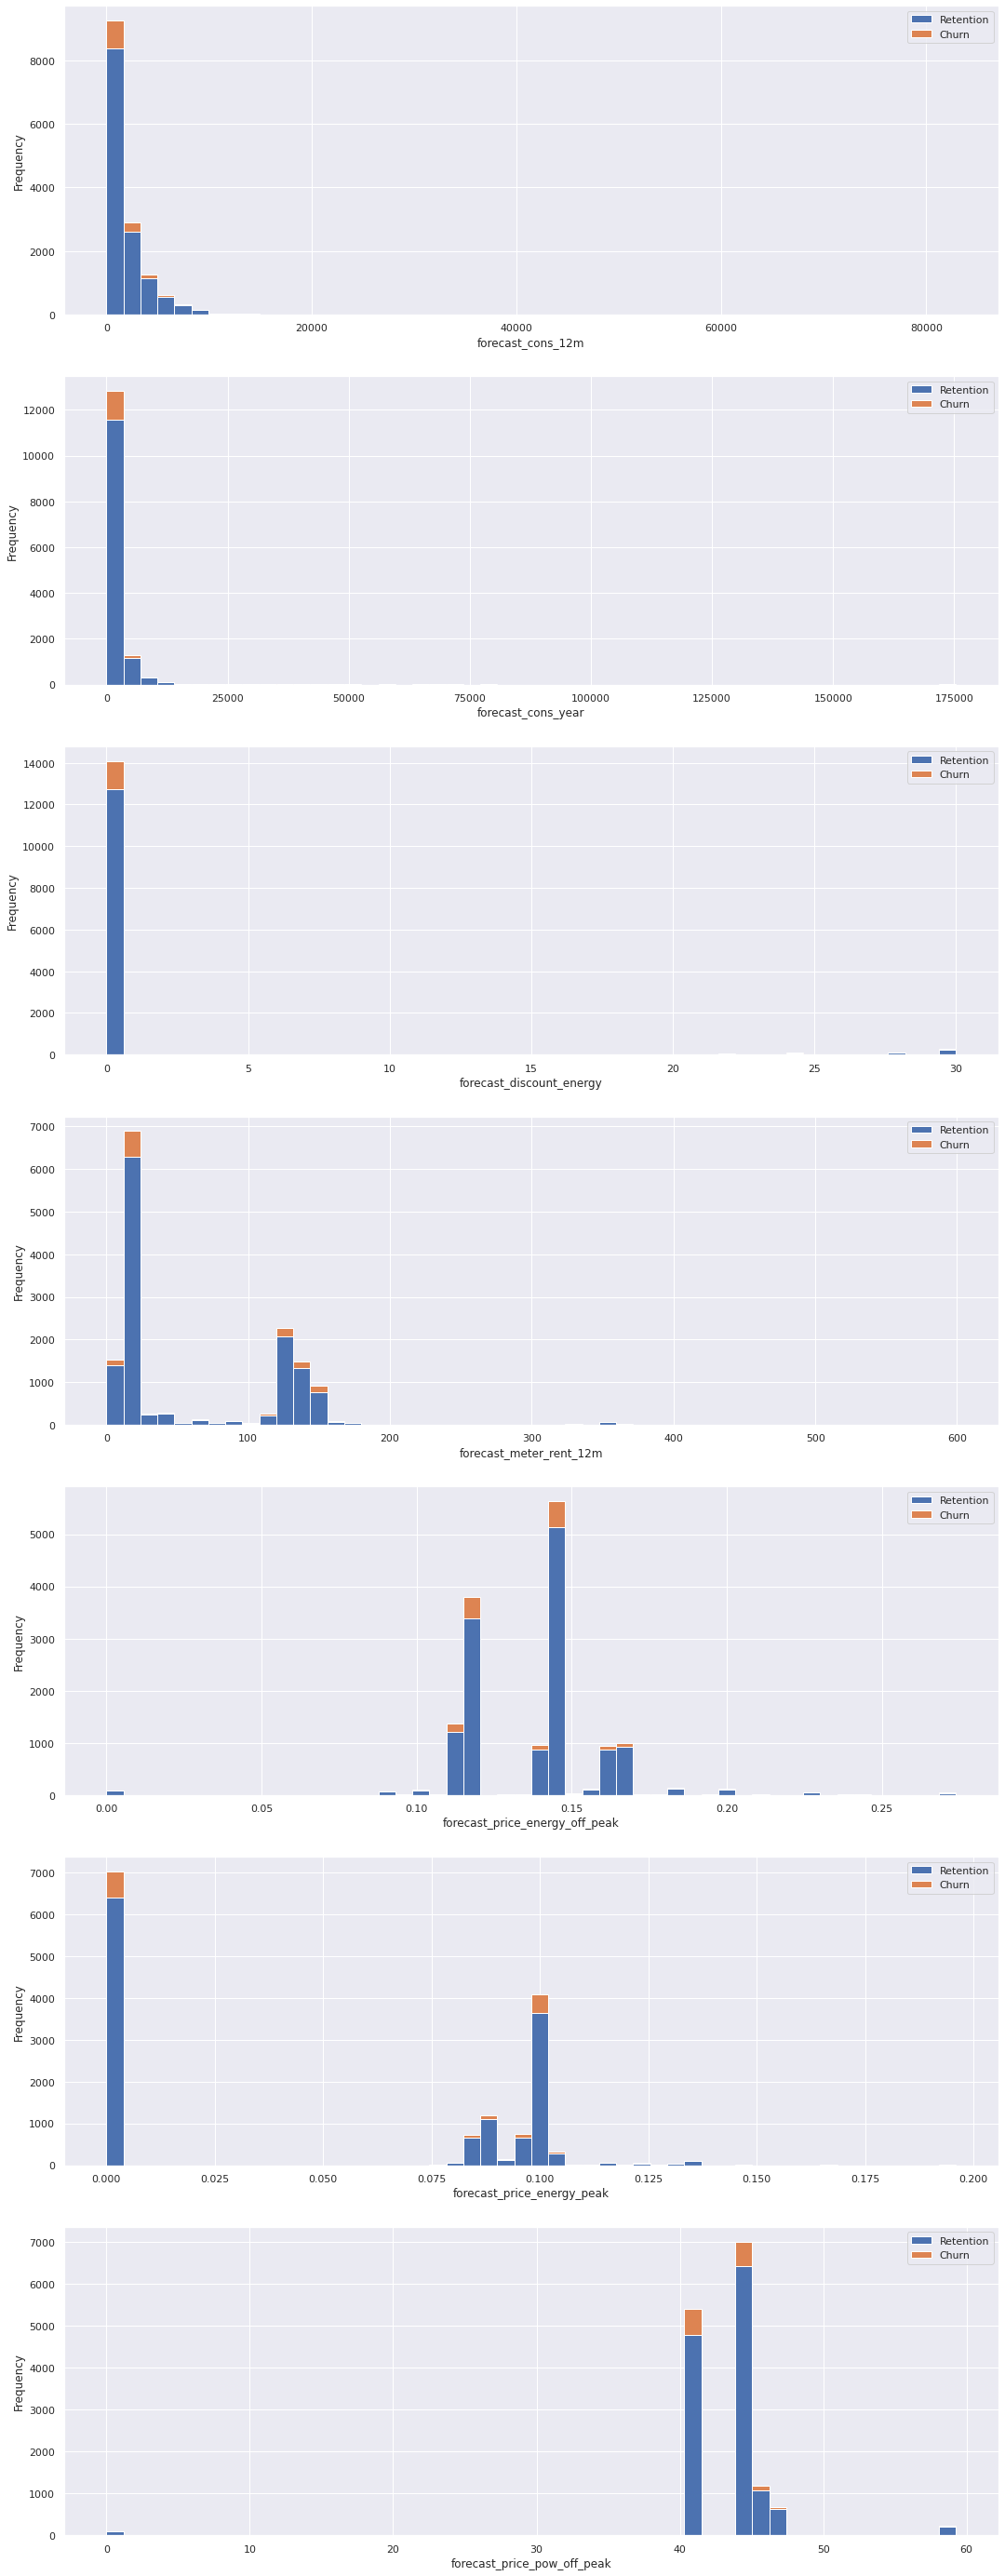

In [ ]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))

# Plot histogram
plot_distribution(client, "forecast_cons_12m", axs[0])
plot_distribution(client, "forecast_cons_year", axs[1])
plot_distribution(client, "forecast_discount_energy", axs[2])
plot_distribution(client, "forecast_meter_rent_12m", axs[3])
plot_distribution(client, "forecast_price_energy_off_peak", axs[4])
plot_distribution(client, "forecast_price_energy_peak", axs[5])
plot_distribution(client, "forecast_price_pow_off_peak", axs[6])


Similarly to the consumption plots, we can observe that a lot of the variables are highly positively
skewed, creating a very long tail for the higher values. We will make some transformations during
the next exercise to correct for this skewness.

### 2.2.4 Contract Type

In [ ]:
contract_type = client[['id', 'has_gas', 'churn']]
contract = contract_type.groupby([contract_type['churn'],contract_type['has_gas']])['id'].count().unstack(level=0)
contract_percentage = (contract.div(contract.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)


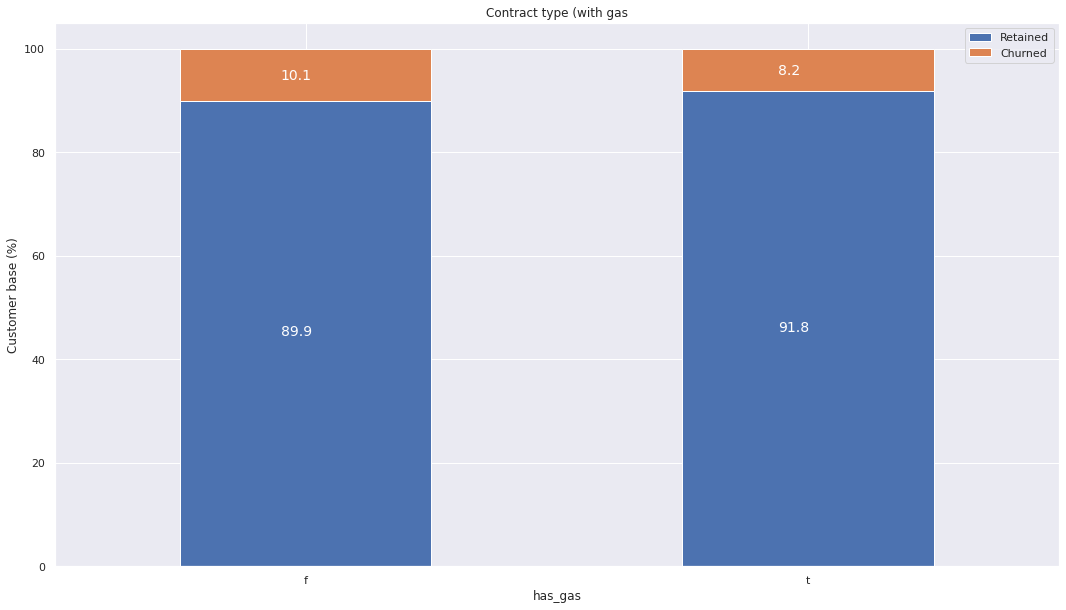

In [ ]:
plot_stacked_bars(contract_percentage, 'Contract type (with gas')

### 2.2.5 Margins

In [ ]:
margin = client[['id', 'margin_gross_pow_ele', 'margin_net_pow_ele','net_margin']]

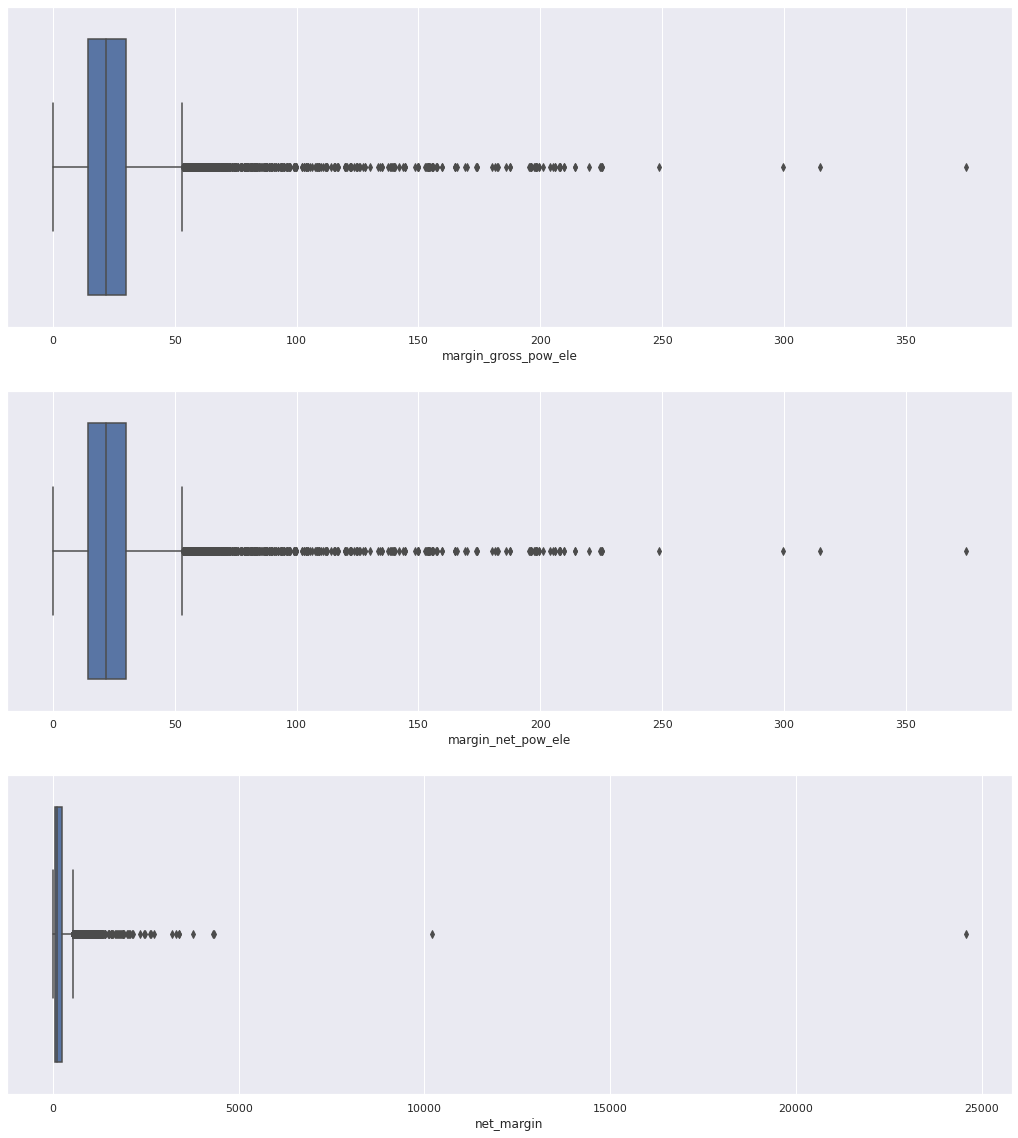

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(18,20))
# Plot histogram
sns.boxplot(margin["margin_gross_pow_ele"], ax=axs[0])
sns.boxplot(margin["margin_net_pow_ele"],ax=axs[1])
sns.boxplot(margin["net_margin"], ax=axs[2])
# Remove scientific notation
axs[0].ticklabel_format(style='plain', axis='x')
axs[1].ticklabel_format(style='plain', axis='x')
axs[2].ticklabel_format(style='plain', axis='x')
plt.show()


### 2.2.6 Other Columns

In [ ]:
others = client[['id', 'nb_prod_act', 'num_years_antig', 'origin_up','churn']]
products = others.groupby([others["nb_prod_act"],others["churn"]])["id"].count().unstack(level=1)
products_percentage = (products.div(products.sum(axis=1), axis=0)*100).sort_values(by=[1], ascending=False)


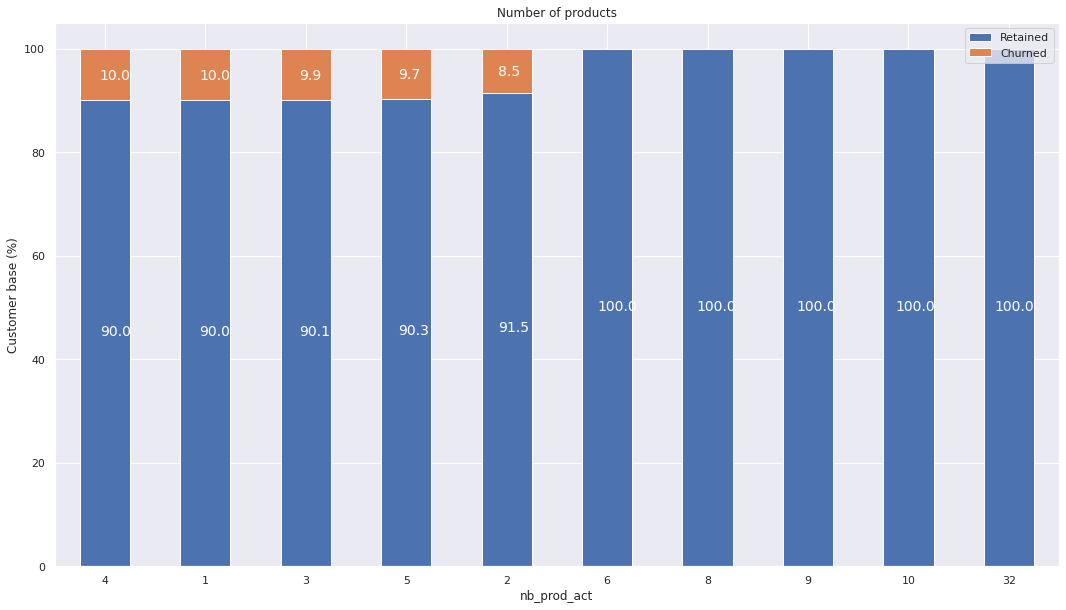

In [ ]:
plot_stacked_bars(products_percentage, "Number of products")

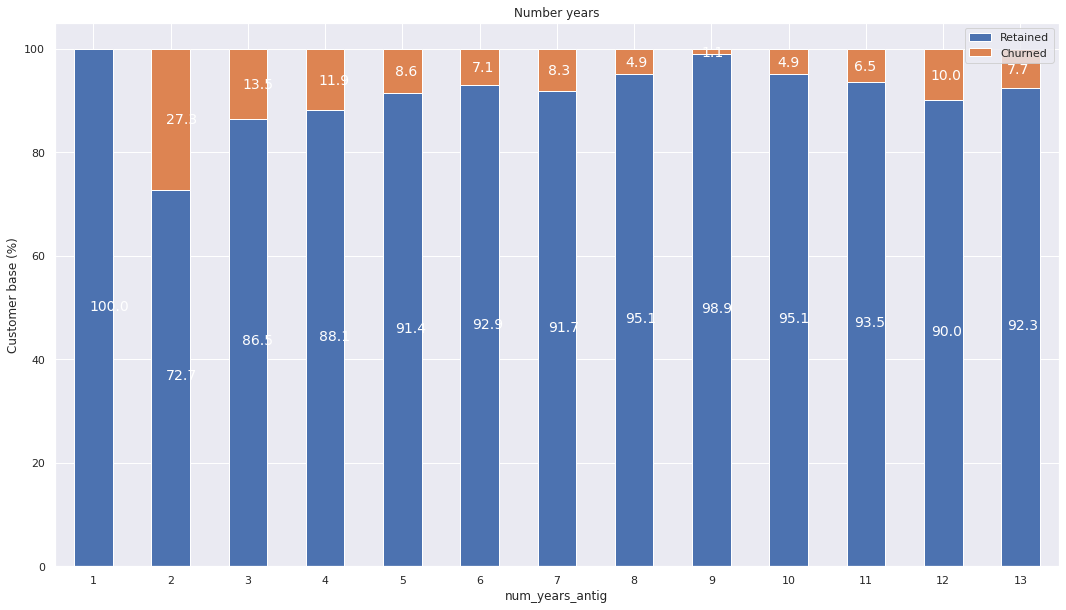

In [ ]:
years_antig = others.groupby([others["num_years_antig"],others["churn"]])["id"].count().unstack(level=1)
years_antig_percentage = (years_antig.div(years_antig.sum(axis=1), axis=0)*100)
plot_stacked_bars(years_antig_percentage, "Number years")

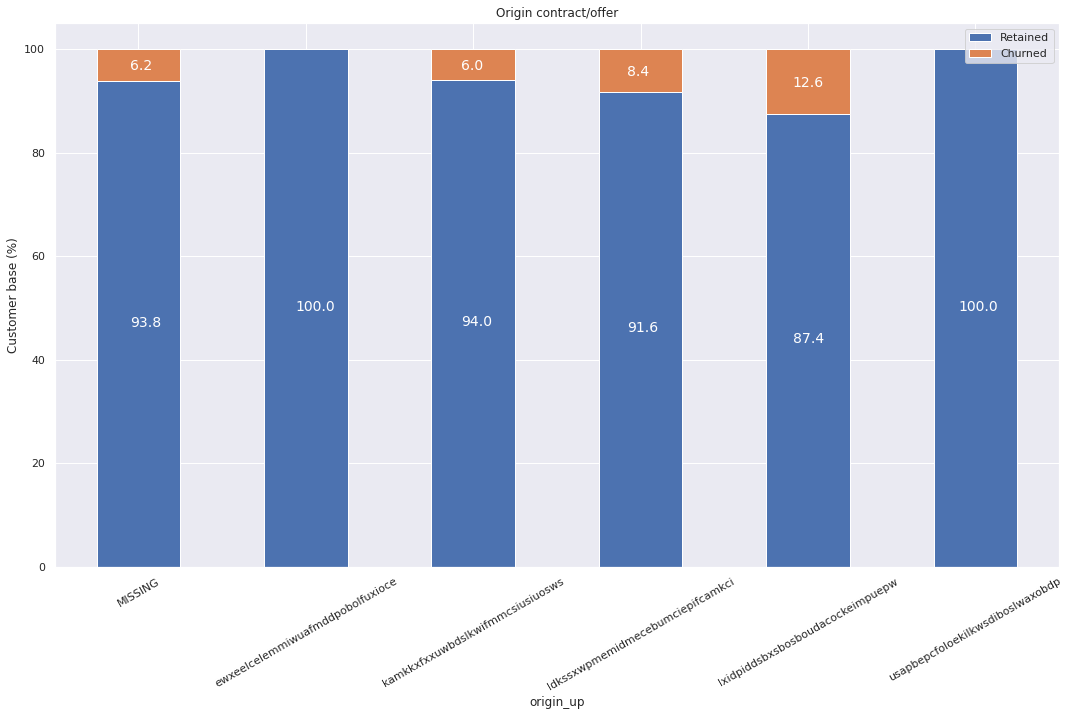

In [ ]:
origin = others.groupby([others["origin_up"],others["churn"]])["id"].count().unstack(level=1)
origin_percentage = (origin.div(origin.sum(axis=1), axis=0)*100)
plot_stacked_bars(origin_percentage, "Origin contract/offer",rot_=30)

### 2.2 7. Hypothesis investigation
Now that we have explored the data, it’s time to investigate whether price sensitivity has some
influence on churn. First we need to define exactly what is price sensitivity.

In [ ]:
# Create yearly sensitivity features
var_year = price.groupby(['id', 'price_date']).mean().groupby(['id']).var().reset_index()


In [ ]:
var_year.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.000016,0.000004,1.871602e-06,4.021438e-03,0.001448,0.000643
1,0010ee3855fdea87602a5b7aba8e42de,0.000025,0.000007,1.627620e-07,7.238536e-03,0.002606,0.001158
2,00114d74e963e47177db89bc70108537,0.000005,0.000000,0.000000e+00,3.490909e-13,0.000000,0.000000
3,001cd16732dc7d5bdf46b0d49996c271,0.000601,0.000000,0.000000e+00,1.230844e+00,0.000000,0.000000
4,001dc71143f45cb58aaccc2e94823c5a,0.000004,0.000000,0.000000e+00,8.619647e-03,0.000000,0.000000


In [ ]:
var_year.columns

Index(['id', 'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var',
       'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix'],
      dtype='object')

In [ ]:
# Create last 6 months sensitivity features
var_6m = price[price['price_date'] > '2015-06-01'].groupby(['id', 'price_date']).mean().groupby(['id']).var().reset_index()

# Rename columns
var_year = var_year.rename(
columns={
"price_off_peak_var": "var_year_price_p1_var",
"price_peak_var": "var_year_price_p2_var",
"price_mid_peak_var": "var_year_price_p3_var",
"price_off_peak_fix": "var_year_price_p1_fix",
"price_peak_fix": "var_year_price_p2_fix",
"price_mid_peak_fix": "var_year_price_p3_fix"
}
)


var_year["var_year_price_p1"] = var_year["var_year_price_p1_var"] + var_year["var_year_price_p1_fix"]
var_year["var_year_price_p2"] = var_year["var_year_price_p2_var"] + var_year["var_year_price_p2_fix"]
var_year["var_year_price_p3"] = var_year["var_year_price_p3_var"] + var_year["var_year_price_p3_fix"]

var_6m = var_6m.rename(
columns={
"price_off_peak_var": "var_6m_price_p1_var",
"price_peak_var": "var_6m_price_p2_var",
"price_mid_peak_var": "var_6m_price_p3_var",
"price_off_peak_fix": "var_6m_price_p1_fix",
"price_peak_fix": "var_6m_price_p2_fix",
"price_mid_peak_fix": "var_6m_price_p3_fix"
}
)

var_6m["var_6m_price_p1"] = var_6m["var_6m_price_p1_var"] + var_6m["var_6m_price_p1_fix"]
var_6m["var_6m_price_p2"] = var_6m["var_6m_price_p2_var"] + var_6m["var_6m_price_p2_fix"]
var_6m["var_6m_price_p3"] = var_6m["var_6m_price_p3_var"] + var_6m["var_6m_price_p3_fix"]

# Merge into 1 dataframe
price_features = pd.merge(var_year, var_6m, on='id')

In [ ]:
price_features.head()

,id,var_year_price_p1_var,var_year_price_p2_var,var_year_price_p3_var,var_year_price_p1_fix,var_year_price_p2_fix,var_year_price_p3_fix,var_year_price_p1,var_year_price_p2,var_year_price_p3,var_6m_price_p1_var,var_6m_price_p2_var,var_6m_price_p3_var,var_6m_price_p1_fix,var_6m_price_p2_fix,var_6m_price_p3_fix,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3
0,0002203ffbb812588b632b9e628cc38d,0.000016,0.000004,1.871602e-06,4.021438e-03,0.001448,0.000643,0.004037,0.001452,0.000645,0.000011,0.000003,4.860000e-10,0.000000,0.0,0.0,0.000011,0.000003,4.860000e-10
1,0010ee3855fdea87602a5b7aba8e42de,0.000025,0.000007,1.627620e-07,7.238536e-03,0.002606,0.001158,0.007264,0.002613,0.001158,0.000011,0.000003,4.860000e-10,0.000000,0.0,0.0,0.000011,0.000003,4.860000e-10
2,00114d74e963e47177db89bc70108537,0.000005,0.000000,0.000000e+00,3.490909e-13,0.000000,0.000000,0.000005,0.000000,0.000000,0.000003,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000003,0.000000,0.000000e+00
3,001cd16732dc7d5bdf46b0d49996c271,0.000601,0.000000,0.000000e+00,1.230844e+00,0.000000,0.000000,1.231445,0.000000,0.000000,0.000370,0.000000,0.000000e+00,0.666667,0.0,0.0,0.667037,0.000000,0.000000e+00
4,001dc71143f45cb58aaccc2e94823c5a,0.000004,0.000000,0.000000e+00,8.619647e-03,0.000000,0.000000,0.008624,0.000000,0.000000,0.000003,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000003,0.000000,0.000000e+00


In [ ]:
price_analysis = pd.merge(price_features, client[['id', 'churn']], on='id')
price_analysis.head()

,id,var_year_price_p1_var,var_year_price_p2_var,var_year_price_p3_var,var_year_price_p1_fix,var_year_price_p2_fix,var_year_price_p3_fix,var_year_price_p1,var_year_price_p2,var_year_price_p3,var_6m_price_p1_var,var_6m_price_p2_var,var_6m_price_p3_var,var_6m_price_p1_fix,var_6m_price_p2_fix,var_6m_price_p3_fix,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,churn
0,0002203ffbb812588b632b9e628cc38d,0.000016,0.000004,0.000002,4.021438e-03,0.001448,0.000643,0.004037,0.001452,0.000645,0.000011,0.000003,4.860000e-10,0.000000,0.0,0.0,0.000011,0.000003,4.860000e-10,0
1,00114d74e963e47177db89bc70108537,0.000005,0.000000,0.000000,3.490909e-13,0.000000,0.000000,0.000005,0.000000,0.000000,0.000003,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000003,0.000000,0.000000e+00,0
2,001cd16732dc7d5bdf46b0d49996c271,0.000601,0.000000,0.000000,1.230844e+00,0.000000,0.000000,1.231445,0.000000,0.000000,0.000370,0.000000,0.000000e+00,0.666667,0.0,0.0,0.667037,0.000000,0.000000e+00,0
3,001dc71143f45cb58aaccc2e94823c5a,0.000004,0.000000,0.000000,8.619647e-03,0.000000,0.000000,0.008624,0.000000,0.000000,0.000003,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000003,0.000000,0.000000e+00,0
4,002b3009d069858b471918402fb237b7,0.000009,0.000003,0.000000,0.000000e+00,0.000000,0.000000,0.000009,0.000003,0.000000,0.000006,0.000002,0.000000e+00,0.000000,0.0,0.0,0.000006,0.000002,0.000000e+00,0


##2.3 Multivariate Analysis

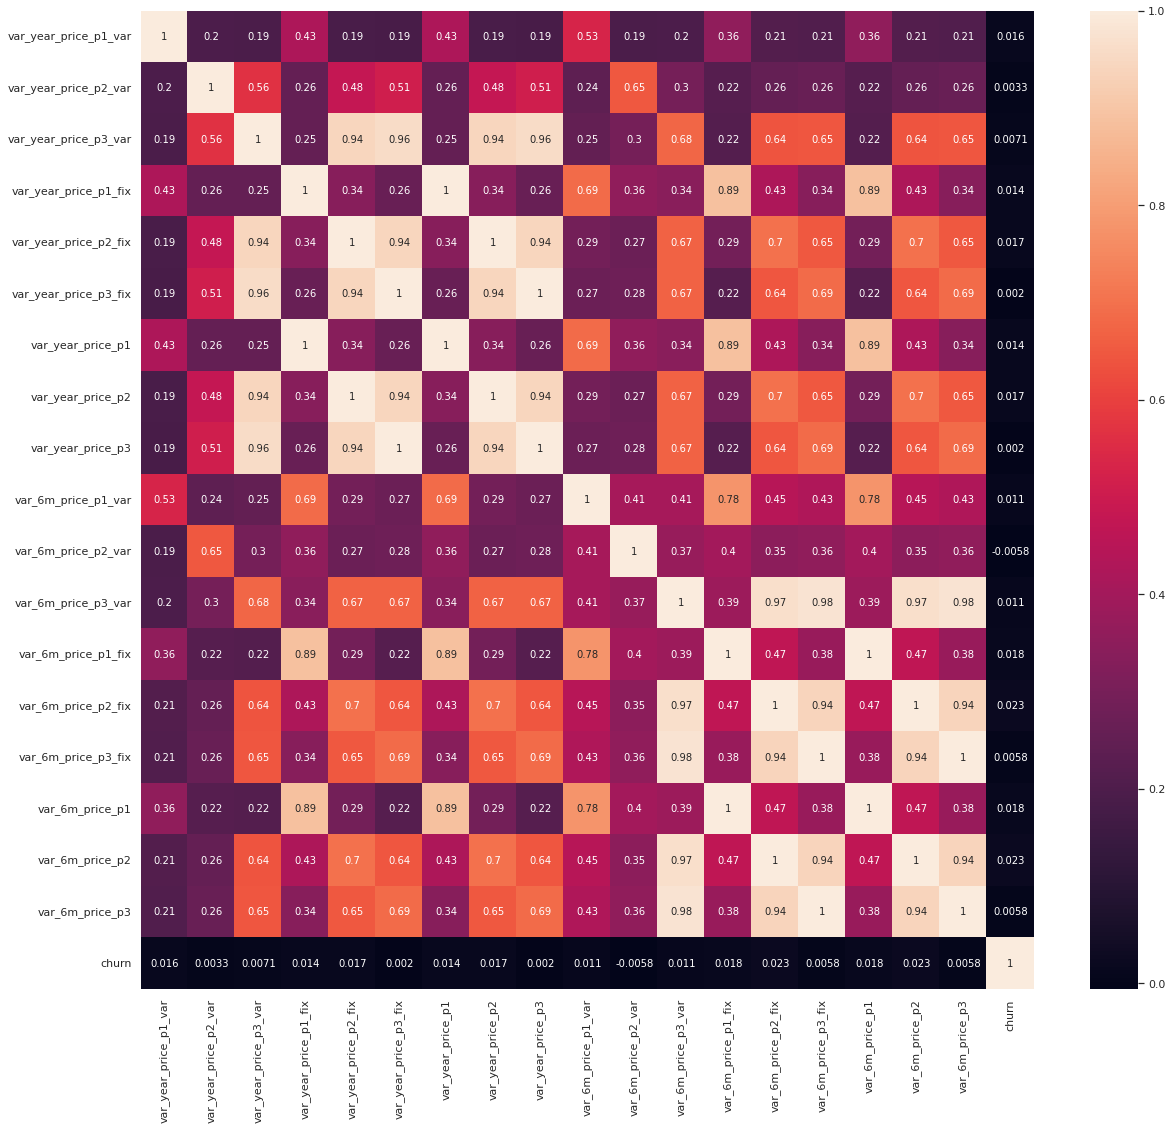

In [ ]:
corr = price_analysis.corr()
# Plot correlation

plt.figure(figsize=(20,18))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':10})
# Axis ticks size plt.xticks(fontsize=10) plt.yticks(fontsize=10)
plt.show()

From the correlation plot, it shows that the price sensitivity features a high inter-correlation with each other, but overall the correlation with churn is very low. This indicates that there is a weak linear relationship between price sensitity and churn. This suggests that for price sensivity to be a major driver for predicting churn, we may need to engineer the features differently.

In [ ]:
merged_data = pd.merge(client.drop(columns=["churn"]), price_analysis, on='id')

In [ ]:
merged_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_p1_var,var_year_price_p2_var,var_year_price_p3_var,var_year_price_p1_fix,var_year_price_p2_fix,var_year_price_p3_fix,var_year_price_p1,var_year_price_p2,var_year_price_p3,var_6m_price_p1_var,var_6m_price_p2_var,var_6m_price_p3_var,var_6m_price_p1_fix,var_6m_price_p2_fix,var_6m_price_p3_fix,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,churn
0,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,5.738446e-06,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,3.569731e-06,9.450150e-08,0.000000e+00,0.000000,0.0,0.0,0.000004,9.450150e-08,0.000000e+00,0
1,01495c955be7ec5e7f3203406785aae0,foosdfpfkusacimwkcsosbicdxkicaua,29552,0,1260,2010-04-21,2016-04-21,2010-04-21,2015-04-22,864.73,751,0.0,144.49,0.115174,0.098837,40.606701,f,70.63,53.92,53.92,1,100.09,6,lxidpiddsbxsbosboudacockeimpuepw,26.400,1.680073e-05,3.398299e-06,0.000002,0.006434,0.002316,0.001029,0.006451,2.319747e-03,0.001032,1.110032e-05,2.896760e-06,4.860000e-10,0.000000,0.0,0.0,0.000011,2.896760e-06,4.860000e-10,0
2,f53a254b1115634330c12c7fdbf7958a,usilxuppasemubllopkaafesmlibmsdf,2962,0,0,2011-09-23,2016-09-23,2011-09-23,2015-09-25,444.38,0,0.0,15.85,0.145711,0.000000,44.311378,f,0.00,12.82,12.82,1,42.59,4,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,4.391109e-06,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006469,0.000000e+00,0.000000,2.842930e-06,0.000000e+00,0.000000e+00,0.009482,0.0,0.0,0.009485,0.000000e+00,0.000000e+00,0
3,d5e512dbc8118a830a7b8c7f61d89992,usilxuppasemubllopkaafesmlibmsdf,10831,0,3112,2011-07-11,2016-07-11,2011-07-11,2015-07-12,1204.58,3112,0.0,20.94,0.164637,0.087381,44.311378,f,349.48,14.52,14.52,1,108.50,5,kamkkxfxxuwbdslkwifmmcsiusiuosws,11.500,6.345630e-07,3.584936e-06,0.000000,0.008380,0.000000,0.000000,0.008381,3.584936e-06,0.000000,3.988682e-07,2.253388e-06,0.000000e+00,0.005268,0.0,0.0,0.005268,2.253388e-06,0.000000e+00,0
4,6ee77a019251bcc304c88167e0dfcb4c,foosdfpfkusacimwkcsosbicdxkicaua,4442,0,2489,2009-11-26,2016-11-26,2009-11-26,2015-11-27,561.96,2489,0.0,20.50,0.167086,0.088444,46.305378,f,308.41,21.09,21.09,1,18.41,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,10.392,4.038151e-06,2.347855e-07,0.000000,0.368650,0.000000,0.000000,0.368654,2.347855e-07,0.000000,3.817295e-06,4.949706e-07,0.000000e+00,0.666667,0.0,0.0,0.666671,4.949706e-07,0.000000e+00,0


EDA Summary
Findings


● Approximately 10% of customers have churned

● Consumption data is highly skewed and must be treated before modelling

● There are outliers present in the data and these must be treated before modelling


● Price sensitivity has a low correlation with churn


● Feature engineering will be vital, especially if we are to increase the predictive power of price
sensitivity



Suggestions


● Competitor price data - perhaps a client is more likely to churn if a competitor has a good offer
available?


● Average Utilities prices across the country - if PowerCo’s prices are way above or below the country
average, will a client be likely to churn?


● Client feedback - a track record of any complaints, calls or feedback provided by the client to
PowerCo might reveal if a client is likely to churn

#3.0 Feature Engineering

In [ ]:
df1 = merged_data.copy()

In [ ]:
df1.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_p1_var,var_year_price_p2_var,var_year_price_p3_var,var_year_price_p1_fix,var_year_price_p2_fix,var_year_price_p3_fix,var_year_price_p1,var_year_price_p2,var_year_price_p3,var_6m_price_p1_var,var_6m_price_p2_var,var_6m_price_p3_var,var_6m_price_p1_fix,var_6m_price_p2_fix,var_6m_price_p3_fix,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,churn
0,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,5.738446e-06,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,3.569731e-06,9.450150e-08,0.000000e+00,0.000000,0.0,0.0,0.000004,9.450150e-08,0.000000e+00,0
1,01495c955be7ec5e7f3203406785aae0,foosdfpfkusacimwkcsosbicdxkicaua,29552,0,1260,2010-04-21,2016-04-21,2010-04-21,2015-04-22,864.73,751,0.0,144.49,0.115174,0.098837,40.606701,f,70.63,53.92,53.92,1,100.09,6,lxidpiddsbxsbosboudacockeimpuepw,26.400,1.680073e-05,3.398299e-06,0.000002,0.006434,0.002316,0.001029,0.006451,2.319747e-03,0.001032,1.110032e-05,2.896760e-06,4.860000e-10,0.000000,0.0,0.0,0.000011,2.896760e-06,4.860000e-10,0
2,f53a254b1115634330c12c7fdbf7958a,usilxuppasemubllopkaafesmlibmsdf,2962,0,0,2011-09-23,2016-09-23,2011-09-23,2015-09-25,444.38,0,0.0,15.85,0.145711,0.000000,44.311378,f,0.00,12.82,12.82,1,42.59,4,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,4.391109e-06,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006469,0.000000e+00,0.000000,2.842930e-06,0.000000e+00,0.000000e+00,0.009482,0.0,0.0,0.009485,0.000000e+00,0.000000e+00,0
3,d5e512dbc8118a830a7b8c7f61d89992,usilxuppasemubllopkaafesmlibmsdf,10831,0,3112,2011-07-11,2016-07-11,2011-07-11,2015-07-12,1204.58,3112,0.0,20.94,0.164637,0.087381,44.311378,f,349.48,14.52,14.52,1,108.50,5,kamkkxfxxuwbdslkwifmmcsiusiuosws,11.500,6.345630e-07,3.584936e-06,0.000000,0.008380,0.000000,0.000000,0.008381,3.584936e-06,0.000000,3.988682e-07,2.253388e-06,0.000000e+00,0.005268,0.0,0.0,0.005268,2.253388e-06,0.000000e+00,0
4,6ee77a019251bcc304c88167e0dfcb4c,foosdfpfkusacimwkcsosbicdxkicaua,4442,0,2489,2009-11-26,2016-11-26,2009-11-26,2015-11-27,561.96,2489,0.0,20.50,0.167086,0.088444,46.305378,f,308.41,21.09,21.09,1,18.41,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,10.392,4.038151e-06,2.347855e-07,0.000000,0.368650,0.000000,0.000000,0.368654,2.347855e-07,0.000000,3.817295e-06,4.949706e-07,0.000000e+00,0.666667,0.0,0.0,0.666671,4.949706e-07,0.000000e+00,0


In [ ]:
price = pd.read_csv('price_data.csv')
price["price_date"] = pd.to_datetime(price["price_date"], format='%Y-%m-%d')
price.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [ ]:
# Group off-peak prices by companies and month
monthly_price_by_id = price.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
2,00114d74e963e47177db89bc70108537,-0.003994,-0.000001
3,00126c87cf78d7604278f0a9adeb689e,-0.012908,0.162916
4,0019baf3ed1242cd99b3cb592030446f,0.118869,14.939999


In [ ]:
df1 = pd.merge(df1, diff, on='id')
df1.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_p1_var,var_year_price_p2_var,var_year_price_p3_var,var_year_price_p1_fix,var_year_price_p2_fix,var_year_price_p3_fix,var_year_price_p1,var_year_price_p2,var_year_price_p3,var_6m_price_p1_var,var_6m_price_p2_var,var_6m_price_p3_var,var_6m_price_p1_fix,var_6m_price_p2_fix,var_6m_price_p3_fix,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,5.738446e-06,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,3.569731e-06,9.450150e-08,0.000000e+00,0.000000,0.0,0.0,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779
1,01495c955be7ec5e7f3203406785aae0,foosdfpfkusacimwkcsosbicdxkicaua,29552,0,1260,2010-04-21,2016-04-21,2010-04-21,2015-04-22,864.73,751,0.0,144.49,0.115174,0.098837,40.606701,f,70.63,53.92,53.92,1,100.09,6,lxidpiddsbxsbosboudacockeimpuepw,26.400,1.680073e-05,3.398299e-06,0.000002,0.006434,0.002316,0.001029,0.006451,2.319747e-03,0.001032,1.110032e-05,2.896760e-06,4.860000e-10,0.000000,0.0,0.0,0.000011,2.896760e-06,4.860000e-10,0,-0.007801,0.162916
2,f53a254b1115634330c12c7fdbf7958a,usilxuppasemubllopkaafesmlibmsdf,2962,0,0,2011-09-23,2016-09-23,2011-09-23,2015-09-25,444.38,0,0.0,15.85,0.145711,0.000000,44.311378,f,0.00,12.82,12.82,1,42.59,4,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,4.391109e-06,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006469,0.000000e+00,0.000000,2.842930e-06,0.000000e+00,0.000000e+00,0.009482,0.0,0.0,0.009485,0.000000e+00,0.000000e+00,0,-0.003767,0.177779
3,d5e512dbc8118a830a7b8c7f61d89992,usilxuppasemubllopkaafesmlibmsdf,10831,0,3112,2011-07-11,2016-07-11,2011-07-11,2015-07-12,1204.58,3112,0.0,20.94,0.164637,0.087381,44.311378,f,349.48,14.52,14.52,1,108.50,5,kamkkxfxxuwbdslkwifmmcsiusiuosws,11.500,6.345630e-07,3.584936e-06,0.000000,0.008380,0.000000,0.000000,0.008381,3.584936e-06,0.000000,3.988682e-07,2.253388e-06,0.000000e+00,0.005268,0.0,0.0,0.005268,2.253388e-06,0.000000e+00,0,-0.001547,0.177779
4,6ee77a019251bcc304c88167e0dfcb4c,foosdfpfkusacimwkcsosbicdxkicaua,4442,0,2489,2009-11-26,2016-11-26,2009-11-26,2015-11-27,561.96,2489,0.0,20.50,0.167086,0.088444,46.305378,f,308.41,21.09,21.09,1,18.41,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,10.392,4.038151e-06,2.347855e-07,0.000000,0.368650,0.000000,0.000000,0.368654,2.347855e-07,0.000000,3.817295e-06,4.949706e-07,0.000000e+00,0.666667,0.0,0.0,0.666671,4.949706e-07,0.000000e+00,0,-0.001496,2.177779


## Average price changes across periods

We can now enhance the feature that our colleague made by calculating the average price changes across individual periods, instead of the entire year.

In [ ]:
# Aggregate average prices per period by company
mean_prices = price.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [ ]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [ ]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df1 = pd.merge(df1, mean_prices[columns], on='id')
df1.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_p1_var,var_year_price_p2_var,var_year_price_p3_var,var_year_price_p1_fix,var_year_price_p2_fix,var_year_price_p3_fix,var_year_price_p1,var_year_price_p2,var_year_price_p3,var_6m_price_p1_var,var_6m_price_p2_var,var_6m_price_p3_var,var_6m_price_p1_fix,var_6m_price_p2_fix,var_6m_price_p3_fix,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,5.738446e-06,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,3.569731e-06,9.450150e-08,0.000000e+00,0.000000,0.0,0.0,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
1,01495c955be7ec5e7f3203406785aae0,foosdfpfkusacimwkcsosbicdxkicaua,29552,0,1260,2010-04-21,2016-04-21,2010-04-21,2015-04-22,864.73,751,0.0,144.49,0.115174,0.098837,40.606701,f,70.63,53.92,53.92,1,100.09,6,lxidpiddsbxsbosboudacockeimpuepw,26.400,1.680073e-05,3.398299e-06,0.000002,0.006434,0.002316,0.001029,0.006451,2.319747e-03,0.001032,1.110032e-05,2.896760e-06,4.860000e-10,0.000000,0.0,0.0,0.000011,2.896760e-06,4.860000e-10,0,-0.007801,0.162916,0.020314,0.028965,0.049279,16.269833,8.134914,24.404747
2,f53a254b1115634330c12c7fdbf7958a,usilxuppasemubllopkaafesmlibmsdf,2962,0,0,2011-09-23,2016-09-23,2011-09-23,2015-09-25,444.38,0,0.0,15.85,0.145711,0.000000,44.311378,f,0.00,12.82,12.82,1,42.59,4,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,4.391109e-06,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006469,0.000000e+00,0.000000,2.842930e-06,0.000000e+00,0.000000e+00,0.009482,0.0,0.0,0.009485,0.000000e+00,0.000000e+00,0,-0.003767,0.177779,0.149682,0.000000,0.149682,44.311375,0.000000,44.311375
3,d5e512dbc8118a830a7b8c7f61d89992,usilxuppasemubllopkaafesmlibmsdf,10831,0,3112,2011-07-11,2016-07-11,2011-07-11,2015-07-12,1204.58,3112,0.0,20.94,0.164637,0.087381,44.311378,f,349.48,14.52,14.52,1,108.50,5,kamkkxfxxuwbdslkwifmmcsiusiuosws,11.500,6.345630e-07,3.584936e-06,0.000000,0.008380,0.000000,0.000000,0.008381,3.584936e-06,0.000000,3.988682e-07,2.253388e-06,0.000000e+00,0.005268,0.0,0.0,0.005268,2.253388e-06,0.000000e+00,0,-0.001547,0.177779,0.081795,0.085745,0.167540,44.341005,0.000000,44.341005
4,6ee77a019251bcc304c88167e0dfcb4c,foosdfpfkusacimwkcsosbicdxkicaua,4442,0,2489,2009-11-26,2016-11-26,2009-11-26,2015-11-27,561.96,2489,0.0,20.50,0.167086,0.088444,46.305378,f,308.41,21.09,21.09,1,18.41,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,10.392,4.038151e-06,2.347855e-07,0.000000,0.368650,0.000000,0.000000,0.368654,2.347855e-07,0.000000,3.817295e-06,4.949706e-07,0.000000e+00,0.666667,0.0,0.0,0.666671,4.949706e-07,0.000000e+00,0,-0.001496,2.177779,0.081574,0.087687,0.169261,44.537302,0.000000,44.537302


This feature may be useful because it adds more granularity to the existing feature that my colleague found to be useful. Instead of looking at differences across an entire year, we have now created features that look at mean average price differences across different time periods (`off_peak`, `peak`, `mid_peak`). The dec-jan feature may reveal macro patterns that occur over an entire year, whereas inter-time-period features may reveal patterns on a micro scale between months.

## Max price changes across periods and months

Another way we can enhance the feature from our colleague is to look at the maximum change in prices across periods and months.

In [ ]:
# Aggregate average prices per period by company
mean_prices_by_month = price.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [ ]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']


In [ ]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [ ]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df1 = pd.merge(df1, max_diff_across_periods_months[columns], on='id')
df1.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_p1_var,var_year_price_p2_var,var_year_price_p3_var,var_year_price_p1_fix,var_year_price_p2_fix,var_year_price_p3_fix,var_year_price_p1,var_year_price_p2,var_year_price_p3,var_6m_price_p1_var,var_6m_price_p2_var,var_6m_price_p3_var,var_6m_price_p1_fix,var_6m_price_p2_fix,var_6m_price_p3_fix,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,5.738446e-06,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,3.569731e-06,9.450150e-08,0.000000e+00,0.000000,0.0,0.0,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
1,01495c955be7ec5e7f3203406785aae0,foosdfpfkusacimwkcsosbicdxkicaua,29552,0,1260,2010-04-21,2016-04-21,2010-04-21,2015-04-22,864.73,751,0.0,144.49,0.115174,0.098837,40.606701,f,70.63,53.92,53.92,1,100.09,6,lxidpiddsbxsbosboudacockeimpuepw,26.400,1.680073e-05,3.398299e-06,0.000002,0.006434,0.002316,0.001029,0.006451,2.319747e-03,0.001032,1.110032e-05,2.896760e-06,4.860000e-10,0.000000,0.0,0.0,0.000011,2.896760e-06,4.860000e-10,0,-0.007801,0.162916,0.020314,0.028965,0.049279,16.269833,8.134914,24.404747,0.022581,0.031859,0.054440,16.291555,8.145775,24.43733
2,f53a254b1115634330c12c7fdbf7958a,usilxuppasemubllopkaafesmlibmsdf,2962,0,0,2011-09-23,2016-09-23,2011-09-23,2015-09-25,444.38,0,0.0,15.85,0.145711,0.000000,44.311378,f,0.00,12.82,12.82,1,42.59,4,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,4.391109e-06,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006469,0.000000e+00,0.000000,2.842930e-06,0.000000e+00,0.000000e+00,0.009482,0.0,0.0,0.009485,0.000000e+00,0.000000e+00,0,-0.003767,0.177779,0.149682,0.000000,0.149682,44.311375,0.000000,44.311375,0.151367,0.000000,0.151367,44.444710,0.000000,44.44471
3,d5e512dbc8118a830a7b8c7f61d89992,usilxuppasemubllopkaafesmlibmsdf,10831,0,3112,2011-07-11,2016-07-11,2011-07-11,2015-07-12,1204.58,3112,0.0,20.94,0.164637,0.087381,44.311378,f,349.48,14.52,14.52,1,108.50,5,kamkkxfxxuwbdslkwifmmcsiusiuosws,11.500,6.345630e-07,3.584936e-06,0.000000,0.008380,0.000000,0.000000,0.008381,3.584936e-06,0.000000,3.988682e-07,2.253388e-06,0.000000e+00,0.005268,0.0,0.0,0.005268,2.253388e-06,0.000000e+00,0,-0.001547,0.177779,0.081795,0.085745,0.167540,44.341005,0.000000,44.341005,0.083972,0.087890,0.168185,44.444710,0.000000,44.44471
4,6ee77a019251bcc304c88167e0dfcb4c,foosdfpfkusacimwkcsosbicdxkicaua,4442,0,2489,2009-11-26,2016-11-26,2009-11-26,2015-11-27,561.96,2489,0.0,20.50,0.167086,0.088444,46.305378,f,308.41,21.09,21.09,1,18.41,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,10.392,4.038151e-06,2.347855e-07,0.000000,0.368650,0.000000,0.000000,0.368654,2.347855e-07,0.000000,3.817295e-06,4.949706e-07,0.000000e+00,0.666667,0.0,0.0,0.666671,4.949706e-07,0.000000e+00,0,-0.001496,2.177779,0.081574,0.087687,0.169261,44.537302,0.000000,44.537302,0.083265,0.088956,0.171266,46.444710,0.000000,46.44471


I thought that calculating the maximum price change between months and time periods would be a good feature to create because I was trying to think from the perspective of a PowerCo client. As a Utilities customer, there is nothing more annoying than sudden price changes between months, and a large increase in prices within a short time span would be an influencing factor in causing me to look at other utilities providers for a better deal. Since we are trying to predict churn for this use case, I thought this would be an interesting feature to include.

Tenure


How long a company has been a client of PowerCo

In [ ]:
df1['tenure'] = ((df1['date_end'] - df1['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)

In [ ]:
df1.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
tenure,
2,0.144068
3,0.139785
4,0.135393
13,0.133333
6,0.082084
5,0.079310
12,0.076923
7,0.074640
8,0.070175


We can see that companies who have only been a client for 4 or less months are much more likely to churn compared to companies that have been a client for longer. Interestingly, the difference between 4 and 5 months is about 4%, which represents a large jump in likelihood for a customer to churn compared to the other differences between ordered tenure values. Perhaps this reveals that getting a customer to over 4 months tenure is actually a large milestone with respect to keeping them as a long term customer. 

This is an interesting feature to keep for modelling because clearly how long you've been a client, has a influence on the chance of a client churning.

### Transforming dates into months

- months_activ = Number of months active until reference date (Jan 2016)
- months_to_end = Number of months of the contract left until reference date (Jan 2016)
- months_modif_prod = Number of months since last modification until reference date (Jan 2016)
- months_renewal = Number of months since last renewal until reference date (Jan 2016)

In [ ]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [ ]:
from datetime import datetime
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df1['months_activ'] = convert_months(reference_date, df1, 'date_activ')
df1['months_to_end'] = -convert_months(reference_date, df1, 'date_end')
df1['months_modif_prod'] = convert_months(reference_date, df1, 'date_modif_prod')
df1['months_renewal'] = convert_months(reference_date, df1, 'date_renewal')

Dates as a datetime object are not useful for a predictive model, so we needed to use the datetimes to create some other features that may hold some predictive power. 

Using intuition, you could assume that a client who has been an active client of PowerCo for a longer amount of time may have more loyalty to the brand and is more likely to stay. Whereas a newer client may be more volatile. Hence the addition of the `months_activ` feature.

As well as this, if we think from the perspective of a client with PowerCo, if you're coming toward the end of your contract with PowerCo your thoughts could go a few ways. You could be looking for better deals for when your contract ends, or you might want to see out your contract and sign another one. One the other hand if you've only just joined, you may have a period where you're allowed to leave if you're not satisfied. Furthermore, if you're in the middle of your contract, their may be charges if you wanted to leave, deterring clients from churning mid-way through their agreement. So, I think `months_to_end` will be an interesting feature because it may reveal patterns and behaviours about timing of churn.

My belief is that if a client has made recent updates to their contract, they are more likely to be satisfied or at least they have received a level of customer service to update or change their existing services. I believe this to be a positive sign, they are an engaged customer, and so I believe `months_modif_prod` will be an interesting feature to include because it shows the degree of how 'engaged' a client is with PowerCo.

Finally the number of months since a client last renewed a contract I believe will be an interesting feature because once again, it shows the degree to which that client is engaged. It also goes a step further than just engagement, it shows a level of commitment if a client renews their contract. For this reason, I believe `months_renewal` will be a good feature to include.

In [ ]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df1 = df1.drop(columns=remove)
df1.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_p1_var,var_year_price_p2_var,var_year_price_p3_var,var_year_price_p1_fix,var_year_price_p2_fix,var_year_price_p3_fix,var_year_price_p1,var_year_price_p2,var_year_price_p3,var_6m_price_p1_var,var_6m_price_p2_var,var_6m_price_p3_var,var_6m_price_p1_fix,var_6m_price_p2_fix,var_6m_price_p3_fix,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,5.738446e-06,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,3.569731e-06,9.450150e-08,0.000000e+00,0.000000,0.0,0.0,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,3,68,8
1,01495c955be7ec5e7f3203406785aae0,foosdfpfkusacimwkcsosbicdxkicaua,29552,0,1260,864.73,751,0.0,144.49,0.115174,0.098837,40.606701,f,70.63,53.92,53.92,1,100.09,6,lxidpiddsbxsbosboudacockeimpuepw,26.400,1.680073e-05,3.398299e-06,0.000002,0.006434,0.002316,0.001029,0.006451,2.319747e-03,0.001032,1.110032e-05,2.896760e-06,4.860000e-10,0.000000,0.0,0.0,0.000011,2.896760e-06,4.860000e-10,0,-0.007801,0.162916,0.020314,0.028965,0.049279,16.269833,8.134914,24.404747,0.022581,0.031859,0.054440,16.291555,8.145775,24.43733,6,68,3,68,8
2,f53a254b1115634330c12c7fdbf7958a,usilxuppasemubllopkaafesmlibmsdf,2962,0,0,444.38,0,0.0,15.85,0.145711,0.000000,44.311378,f,0.00,12.82,12.82,1,42.59,4,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,4.391109e-06,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006469,0.000000e+00,0.000000,2.842930e-06,0.000000e+00,0.000000e+00,0.009482,0.0,0.0,0.009485,0.000000e+00,0.000000e+00,0,-0.003767,0.177779,0.149682,0.000000,0.149682,44.311375,0.000000,44.311375,0.151367,0.000000,0.151367,44.444710,0.000000,44.44471,5,51,8,51,3
3,d5e512dbc8118a830a7b8c7f61d89992,usilxuppasemubllopkaafesmlibmsdf,10831,0,3112,1204.58,3112,0.0,20.94,0.164637,0.087381,44.311378,f,349.48,14.52,14.52,1,108.50,5,kamkkxfxxuwbdslkwifmmcsiusiuosws,11.500,6.345630e-07,3.584936e-06,0.000000,0.008380,0.000000,0.000000,0.008381,3.584936e-06,0.000000,3.988682e-07,2.253388e-06,0.000000e+00,0.005268,0.0,0.0,0.005268,2.253388e-06,0.000000e+00,0,-0.001547,0.177779,0.081795,0.085745,0.167540,44.341005,0.000000,44.341005,0.083972,0.087890,0.168185,44.444710,0.000000,44.44471,5,53,6,53,5
4,6ee77a019251bcc304c88167e0dfcb4c,foosdfpfkusacimwkcsosbicdxkicaua,4442,0,2489,561.96,2489,0.0,20.50,0.167086,0.088444,46.305378,f,308.41,21.09,21.09,1,18.41,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,10.392,4.038151e-06,2.347855e-07,0.000000,0.368650,0.000000,0.000000,0.368654,2.347855e-07,0.000000,3.817295e-06,4.949706e-07,0.000000e+00,0.666667,0.0,0.0,0.666671,4.949706e-07,0.000000e+00,0,-0.001496,2.177779,0.081574,0.087687,0.169261,44.537302,0.000000,44.537302,0.083265,0.088956,0.171266,46.444710,0.000000,46.44471,7,73,10,73,1


### Transforming Boolean data

#### has_gas

We simply want to transform this column from being categorical to being a binary flag

In [ ]:
df1['has_gas'] = df1['has_gas'].replace(['t', 'f'], [1, 0])
df1.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.103076
1,0.081633


If a customer also buys gas from PowerCo, it shows that they have multiple products and are a loyal customer to the brand. Hence, it is no surprise that customers who do not buy gas are almost 2% more likely to churn than customers who also buy gas from PowerCo. Hence, this is a useful feature.

### Transforming categorical data

A predictive model cannot accept categorical or `string` values, hence as a data scientist you need to encode categorical features into numerical representations in the most compact and discriminative way possible.

The simplest method is to map each category to an integer (label encoding), however this is not always appropriate beecause it then introduces the concept of an order into a feature which may not inherently be present `0 < 1 < 2 < 3 ...`

Another way to encode categorical features is to use `dummy variables` AKA `one hot encoding`. This create a new feature for every unique value of a categorical column, and fills this column with either a 1 or a 0 to indicate that this company does or does not belong to this category.

#### channel_sales

In [ ]:
# Transform into categorical type
df1['channel_sales'] = df1['channel_sales'].astype('category')

# Let's see how many categories are within this column
df1['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    3141
MISSING                             1640
lmkebamcaaclubfxadlmueccxoimlema     823
usilxuppasemubllopkaafesmlibmsdf     644
ewpakwlliwisiwduibdlfmalxowmwpci     431
sddiedcslfslkckwlfkdpoeeailfpeds       6
epumfxlbckeskwekxbiuasklxalciiuu       1
fixdbufsefwooaasfcxdxadsiekoceaa       1
Name: channel_sales, dtype: int64

We have 8 categories, so we will create 8 dummy variables from this column. However, as you can see the last 3 categories in the output above, show that they only have 11, 3 and 2 occurrences respectively. Considering that our dataset has about 14000 rows, this means that these dummy variables will be almost entirely 0 and so will not add much predictive power to the model at all (since they're almost entirely a constant value and provide very little).

For this reason, we will drop these 3 dummy variables.

In [ ]:
df1.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_p1_var,var_year_price_p2_var,var_year_price_p3_var,var_year_price_p1_fix,var_year_price_p2_fix,var_year_price_p3_fix,var_year_price_p1,var_year_price_p2,var_year_price_p3,var_6m_price_p1_var,var_6m_price_p2_var,var_6m_price_p3_var,var_6m_price_p1_fix,var_6m_price_p2_fix,var_6m_price_p3_fix,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,5.738446e-06,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,3.569731e-06,9.450150e-08,0.000000e+00,0.000000,0.0,0.0,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,3,68,8
1,01495c955be7ec5e7f3203406785aae0,foosdfpfkusacimwkcsosbicdxkicaua,29552,0,1260,864.73,751,0.0,144.49,0.115174,0.098837,40.606701,0,70.63,53.92,53.92,1,100.09,6,lxidpiddsbxsbosboudacockeimpuepw,26.400,1.680073e-05,3.398299e-06,0.000002,0.006434,0.002316,0.001029,0.006451,2.319747e-03,0.001032,1.110032e-05,2.896760e-06,4.860000e-10,0.000000,0.0,0.0,0.000011,2.896760e-06,4.860000e-10,0,-0.007801,0.162916,0.020314,0.028965,0.049279,16.269833,8.134914,24.404747,0.022581,0.031859,0.054440,16.291555,8.145775,24.43733,6,68,3,68,8
2,f53a254b1115634330c12c7fdbf7958a,usilxuppasemubllopkaafesmlibmsdf,2962,0,0,444.38,0,0.0,15.85,0.145711,0.000000,44.311378,0,0.00,12.82,12.82,1,42.59,4,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,4.391109e-06,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006469,0.000000e+00,0.000000,2.842930e-06,0.000000e+00,0.000000e+00,0.009482,0.0,0.0,0.009485,0.000000e+00,0.000000e+00,0,-0.003767,0.177779,0.149682,0.000000,0.149682,44.311375,0.000000,44.311375,0.151367,0.000000,0.151367,44.444710,0.000000,44.44471,5,51,8,51,3
3,d5e512dbc8118a830a7b8c7f61d89992,usilxuppasemubllopkaafesmlibmsdf,10831,0,3112,1204.58,3112,0.0,20.94,0.164637,0.087381,44.311378,0,349.48,14.52,14.52,1,108.50,5,kamkkxfxxuwbdslkwifmmcsiusiuosws,11.500,6.345630e-07,3.584936e-06,0.000000,0.008380,0.000000,0.000000,0.008381,3.584936e-06,0.000000,3.988682e-07,2.253388e-06,0.000000e+00,0.005268,0.0,0.0,0.005268,2.253388e-06,0.000000e+00,0,-0.001547,0.177779,0.081795,0.085745,0.167540,44.341005,0.000000,44.341005,0.083972,0.087890,0.168185,44.444710,0.000000,44.44471,5,53,6,53,5
4,6ee77a019251bcc304c88167e0dfcb4c,foosdfpfkusacimwkcsosbicdxkicaua,4442,0,2489,561.96,2489,0.0,20.50,0.167086,0.088444,46.305378,0,308.41,21.09,21.09,1,18.41,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,10.392,4.038151e-06,2.347855e-07,0.000000,0.368650,0.000000,0.000000,0.368654,2.347855e-07,0.000000,3.817295e-06,4.949706e-07,0.000000e+00,0.666667,0.0,0.0,0.666671,4.949706e-07,0.000000e+00,0,-0.001496,2.177779,0.081574,0.087687,0.169261,44.537302,0.000000,44.537302,0.083265,0.088956,0.171266,46.444710,0.000000,46.44471,7,73,10,73,1


In [ ]:
df1 = pd.get_dummies(df1, columns=['channel_sales'], prefix='channel')
df1 = df1.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df1.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_p1_var,var_year_price_p2_var,var_year_price_p3_var,var_year_price_p1_fix,var_year_price_p2_fix,var_year_price_p3_fix,var_year_price_p1,var_year_price_p2,var_year_price_p3,var_6m_price_p1_var,var_6m_price_p2_var,var_6m_price_p3_var,var_6m_price_p1_fix,var_6m_price_p2_fix,var_6m_price_p3_fix,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,5.738446e-06,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,3.569731e-06,9.450150e-08,0.000000e+00,0.000000,0.0,0.0,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,3,68,8,0,0,1,0,0
1,01495c955be7ec5e7f3203406785aae0,29552,0,1260,864.73,751,0.0,144.49,0.115174,0.098837,40.606701,0,70.63,53.92,53.92,1,100.09,6,lxidpiddsbxsbosboudacockeimpuepw,26.400,1.680073e-05,3.398299e-06,0.000002,0.006434,0.002316,0.001029,0.006451,2.319747e-03,0.001032,1.110032e-05,2.896760e-06,4.860000e-10,0.000000,0.0,0.0,0.000011,2.896760e-06,4.860000e-10,0,-0.007801,0.162916,0.020314,0.028965,0.049279,16.269833,8.134914,24.404747,0.022581,0.031859,0.054440,16.291555,8.145775,24.43733,6,68,3,68,8,0,0,1,0,0
2,f53a254b1115634330c12c7fdbf7958a,2962,0,0,444.38,0,0.0,15.85,0.145711,0.000000,44.311378,0,0.00,12.82,12.82,1,42.59,4,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,4.391109e-06,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006469,0.000000e+00,0.000000,2.842930e-06,0.000000e+00,0.000000e+00,0.009482,0.0,0.0,0.009485,0.000000e+00,0.000000e+00,0,-0.003767,0.177779,0.149682,0.000000,0.149682,44.311375,0.000000,44.311375,0.151367,0.000000,0.151367,44.444710,0.000000,44.44471,5,51,8,51,3,0,0,0,0,1
3,d5e512dbc8118a830a7b8c7f61d89992,10831,0,3112,1204.58,3112,0.0,20.94,0.164637,0.087381,44.311378,0,349.48,14.52,14.52,1,108.50,5,kamkkxfxxuwbdslkwifmmcsiusiuosws,11.500,6.345630e-07,3.584936e-06,0.000000,0.008380,0.000000,0.000000,0.008381,3.584936e-06,0.000000,3.988682e-07,2.253388e-06,0.000000e+00,0.005268,0.0,0.0,0.005268,2.253388e-06,0.000000e+00,0,-0.001547,0.177779,0.081795,0.085745,0.167540,44.341005,0.000000,44.341005,0.083972,0.087890,0.168185,44.444710,0.000000,44.44471,5,53,6,53,5,0,0,0,0,1
4,6ee77a019251bcc304c88167e0dfcb4c,4442,0,2489,561.96,2489,0.0,20.50,0.167086,0.088444,46.305378,0,308.41,21.09,21.09,1,18.41,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,10.392,4.038151e-06,2.347855e-07,0.000000,0.368650,0.000000,0.000000,0.368654,2.347855e-07,0.000000,3.817295e-06,4.949706e-07,0.000000e+00,0.666667,0.0,0.0,0.666671,4.949706e-07,0.000000e+00,0,-0.001496,2.177779,0.081574,0.087687,0.169261,44.537302,0.000000,44.537302,0.083265,0.088956,0.171266,46.444710,0.000000,46.44471,7,73,10,73,1,0,0,1,0,0


#### Origin Up

In [ ]:
# Transform into categorical type
df1['origin_up'] = df1['origin_up'].astype('category')

# Let's see how many categories are within this column
df1['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    3321
kamkkxfxxuwbdslkwifmmcsiusiuosws    1903
ldkssxwpmemidmecebumciepifcamkci    1429
MISSING                               33
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [ ]:
df1 = pd.get_dummies(df1, columns=['origin_up'], prefix='origin_up')

In [ ]:

df1 = df1.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df1.head()

KeyError: ignored

### Transforming numerical data

In the previous exercise we saw that some variables were highly skewed. The reason why we need to treat skewness is because some predictive models have inherent assumptions about the distribution of the features that are being supplied to it. Such models are called `parametric` models, and they typically assume that all variables are both independent and normally distributed. 

Skewness isn't always a bad thing, but as a rule of thumb it is always good practice to treat highly skewed variables because of the reason stated above, but also as it can improve the speed at which predictive models are able to converge to its best solution.

There are many ways that you can treat skewed variables. You can apply transformations such as:
- Square root
- Cubic root
- Logarithm

to a continuous numeric column and you will notice the distribution changes. For this use case we will use the 'Logarithm' transformation for the positively skewed features. 

<b>Note:</b> We cannot apply log to a value of 0, so we will add a constant of 1 to all the values

First I want to see the statistics of the skewed features, so that we can compare before and after transformation

In [ ]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df1[skewed].describe()

In [ ]:
# Apply log10 transformation
df1["cons_12m"] = np.log10(df1["cons_12m"] + 1)
df1["cons_gas_12m"] = np.log10(df1["cons_gas_12m"] + 1)
df1["cons_last_month"] = np.log10(df1["cons_last_month"] + 1)
df1["forecast_cons_12m"] = np.log10(df1["forecast_cons_12m"] + 1)
df1["forecast_cons_year"] = np.log10(df1["forecast_cons_year"] + 1)
df1["forecast_meter_rent_12m"] = np.log10(df1["forecast_meter_rent_12m"] + 1)
df1["imp_cons"] = np.log10(df1["imp_cons"] + 1)

In [ ]:
df1[skewed].describe()

Now we can see that for the majority of the features, their standard deviation is much lower after transformation. This is a good thing, it shows that these features are more stable and predictable now.

Let's quickly check the distributions of some of these features too.

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df1["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df1[df1["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df1["cons_last_month"].dropna()), ax=axs[2])
plt.show()

In [ ]:
df1= df1.drop(columns=['num_years_antig', 'forecast_cons_year'])
df1.head()

## 4.0 MACHINE LEARNING 

In [ ]:
# Before continuing into sessions that we will implement the Machine Learning models,
# I would like to explain about the error meanings.

# MAE:
# It is usually what I use to report to the business team because is easier to explain.
# It takes the absolute value of the difference between the real and the predicted 
# number and divides it by the number of predictions, that is, for each value that
# the model predicts it varies the MAE value on average (both for more and for less).
# Due to the way the MAE is calculated, it is not sensitive to outliers.
# If I'm on a project where having an outlier-sensitive error is super important 
#I will use to evaluate my model another error.

# MAPE:
# It is also used to facilitate the understanding of the business team about the error of your model. 
# The MAPE simply represents the percentage of the MAE, 
# that is, how much the error that the model has means in percentage of the real value.

# RMSE:
# This is the error most used by data scientists to measure the performance
# of the model and its value serves as a parameter in the process of trying 
# to decrease the model error within the project.
# This high use of RMSE is due to the fact that it is sensitive to outliers 
# and this helps data scientists to be more rigorous with model errors.
# In cases where detecting the presence of outliers is important within 
# the project I use RMSE instead of MAE.

## 4.1 Linear Regression

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from lab_utils_common import dlc

In [ ]:
# Separate Independent and dependent Variable

X = df1[['cons_12m',
        'net_margin',
        'forecast_meter_rent_12m',
        'margin_net_pow_ele',
        'cons_last_month',
        'pow_max',
        'imp_cons',
        'months_activ'

        ]].values

y = df1['churn']

In [ ]:
# Train using 80% of the data.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn import metrics
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# find optimal coefficients and intercept
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

# assess the accuraccy of the model
y_pred = regressor.predict(X_test)

a = pd.DataFrame( {'Model Name': 'Linear Regression',
                  'Mean Absolute Error': metrics.mean_absolute_error(y_test, y_pred), 
                  'Mean Absolute Percentage Error':np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
                  'Mean Squared Error':  metrics.mean_squared_error(y_test, y_pred) , 
                  'Root Mean Squared Error': np.sqrt(metrics.mean_squared_error(y_test, y_pred)) }, index=[0])


In [ ]:
a